In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json

import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

from fuzzywuzzy import process


# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "correct_return_periods.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths, get_logo_path, get_data_paths, setup_root_paths, get_plot_path
setup_project_paths(PATH)


from utils_plotting import plot_country_time_series #, plot_random_monthly_and_yearly_data, plot_feature_histograms, plot_contry_period_map
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
from utils_small_p_i import calculate_p_i
from utils_big_P_i import calculate_P_i

#from utils_likelihoods import calculate_likelihood_of_at_least_one_event

from utils_return_periods import calculate_return_periods

#from utils_global_probabilities import calculate_global_probabilities
#from utils_country_probabilities import calculate_all_country_probabilities
#from utils_check_expected_features import check_expected_features    
from utils_date_index import calculate_date_from_index 

#from utils_country_id_csv_to_json import country_id_csv_to_json

from utils_get_country_names_by_ids import get_country_names_by_ids
from utils_get_country_id_by_name import get_country_id_by_name
from utils_get_time_period import get_time_period

from utils_update_df_with_probabilities_and_return_periods import update_df_with_probabilities_and_return_periods

from utils_get_extended_feature_list import get_extended_feature_list

from utils_process_data_country_wise import process_data_country_wise

from utils_feature_eng_binned_return_periods import feature_eng_binned_return_periods

from utils_update_df_with_binned_return_periods import process_binning

#from process_raw_viewser_data import process_raw_viewser_data

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
PATH_RAW_VIEWSER, PATH_RAW_EXTERNAL, PATH_PROCESSED, PATH_GENERATED = get_data_paths(PATH)

# NOW:

- you need to do somethign with main

- plot everything and anticipate aggregations by make 1x1 part of the folder struture or file name

- Maps plots! 

In [4]:
# load the data from the pkl
df_monthly = pd.read_pickle(PATH_GENERATED / "df_monthly_country_return_periods.pkl")
df_yearly = pd.read_pickle(PATH_GENERATED / "df_yearly_country_return_periods.pkl")

In [5]:
print(f"Looking at contry {get_country_names_by_ids([47])} in 2023. I use bot monthly and yearly data to check the yearly aggregation is correct")

print('Yearly, 2023 sum:')
print(f"Total best for c_id 47 and year_id 2023: {df_yearly[(df_yearly['c_id'] == 47) & (df_yearly['year_id'] == 2023)]['total_best'].sum()}")
print(f"SB best for c_id 47 and year_id 2023: {df_yearly[(df_yearly['c_id'] == 47) & (df_yearly['year_id'] == 2023)]['sb_best'].sum()}")
print(f"NS best for c_id 47 and year_id 2023: {df_yearly[(df_yearly['c_id'] == 47) & (df_yearly['year_id'] == 2023)]['ns_best'].sum()}")
print(f"OS best for c_id 47 and year_id 2023: {df_yearly[(df_yearly['c_id'] == 47) & (df_yearly['year_id'] == 2023)]['os_best'].sum()}")
print(f"Population GPW sum for c_id 47 and year_id 2023: {df_yearly[(df_yearly['c_id'] == 47) & (df_yearly['year_id'] == 2023)]['pop_gpw_sum'].sum()}")
print('\n')

print('Monthly, 2023 sum:')
print(f"Total best for c_id 47 and year_id 2023: {df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023)]['total_best'].sum()}")
print(f"SB best for c_id 47 and year_id 2023: {df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023)]['sb_best'].sum()}")
print(f"NS best for c_id 47 and year_id 2023: {df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023)]['ns_best'].sum()}")
print(f"OS best for c_id 47 and year_id 2023: {df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023)]['os_best'].sum()}")
print(f"Population GPW sum for c_id 47 and year_id 2023: {df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023) & (df_monthly['month'] == 1)]['pop_gpw_sum'].sum()}")
print('\n')

norm = 100000
n_pop = df_yearly[(df_yearly['c_id'] == 47) & (df_yearly['year_id'] == 2023)]['pop_gpw_sum'].sum()
total_fat = df_yearly[(df_yearly['c_id'] == 47) & (df_yearly['year_id'] == 2023)]['total_best'].sum()
fat_per_100k = (total_fat / n_pop) * norm

print(f"Fat per 100k for yearly data: {fat_per_100k}")

# and for the monthly data 12 values
n_pop = df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023) & (df_monthly['month'] == 1)]['pop_gpw_sum'].sum()
total_fat = df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023)]['total_best'].sum()
fat_per_100k = (total_fat / n_pop) * norm

print(f"Fat per 100k monthly data if we sum it to year: {fat_per_100k} (this is just to check that the yearly aggregation is correct)")

Looking at contry {47: 'Burkina Faso'} in 2023. I use bot monthly and yearly data to check the yearly aggregation is correct
Yearly, 2023 sum:
Total best for c_id 47 and year_id 2023: 5835.0
SB best for c_id 47 and year_id 2023: 4332.0
NS best for c_id 47 and year_id 2023: 198.0
OS best for c_id 47 and year_id 2023: 1305.0
Population GPW sum for c_id 47 and year_id 2023: 15520172.37109375


Monthly, 2023 sum:
Total best for c_id 47 and year_id 2023: 5835.0
SB best for c_id 47 and year_id 2023: 4332.0
NS best for c_id 47 and year_id 2023: 198.0
OS best for c_id 47 and year_id 2023: 1305.0
Population GPW sum for c_id 47 and year_id 2023: 15520172.37109375


Fat per 100k for yearly data: 37.59623192631327
Fat per 100k monthly data if we sum it to year: 37.59623192631327 (this is just to check that the yearly aggregation is correct)


In [6]:
# NEEDS TOTALS FOR ALL FAATURES

features = ['sb_best', 'ns_best', 'os_best', 'total_best',
            'pop_gpw_sum', 'total_best_per_100k_country', 
            'sb_best_per_100k_country','os_best_per_100k_country', 'ns_best_per_100k_country']

            # Can we average this in this plt? Or count the number of events? What is the best way to show this?'
            # binning might be the solution bc we can show how many 5 period events, 10 period events, etc. there are in each country over the time periods.
            #'sb_best_p_i', 'sb_best_P_i', 'sb_best_e_i', 'sb_best_E_i', 
            #'ns_best_p_i', 'ns_best_P_i', 'ns_best_e_i', 'ns_best_E_i', 
            #'os_best_p_i', 'os_best_P_i', 'os_best_e_i', 'os_best_E_i']

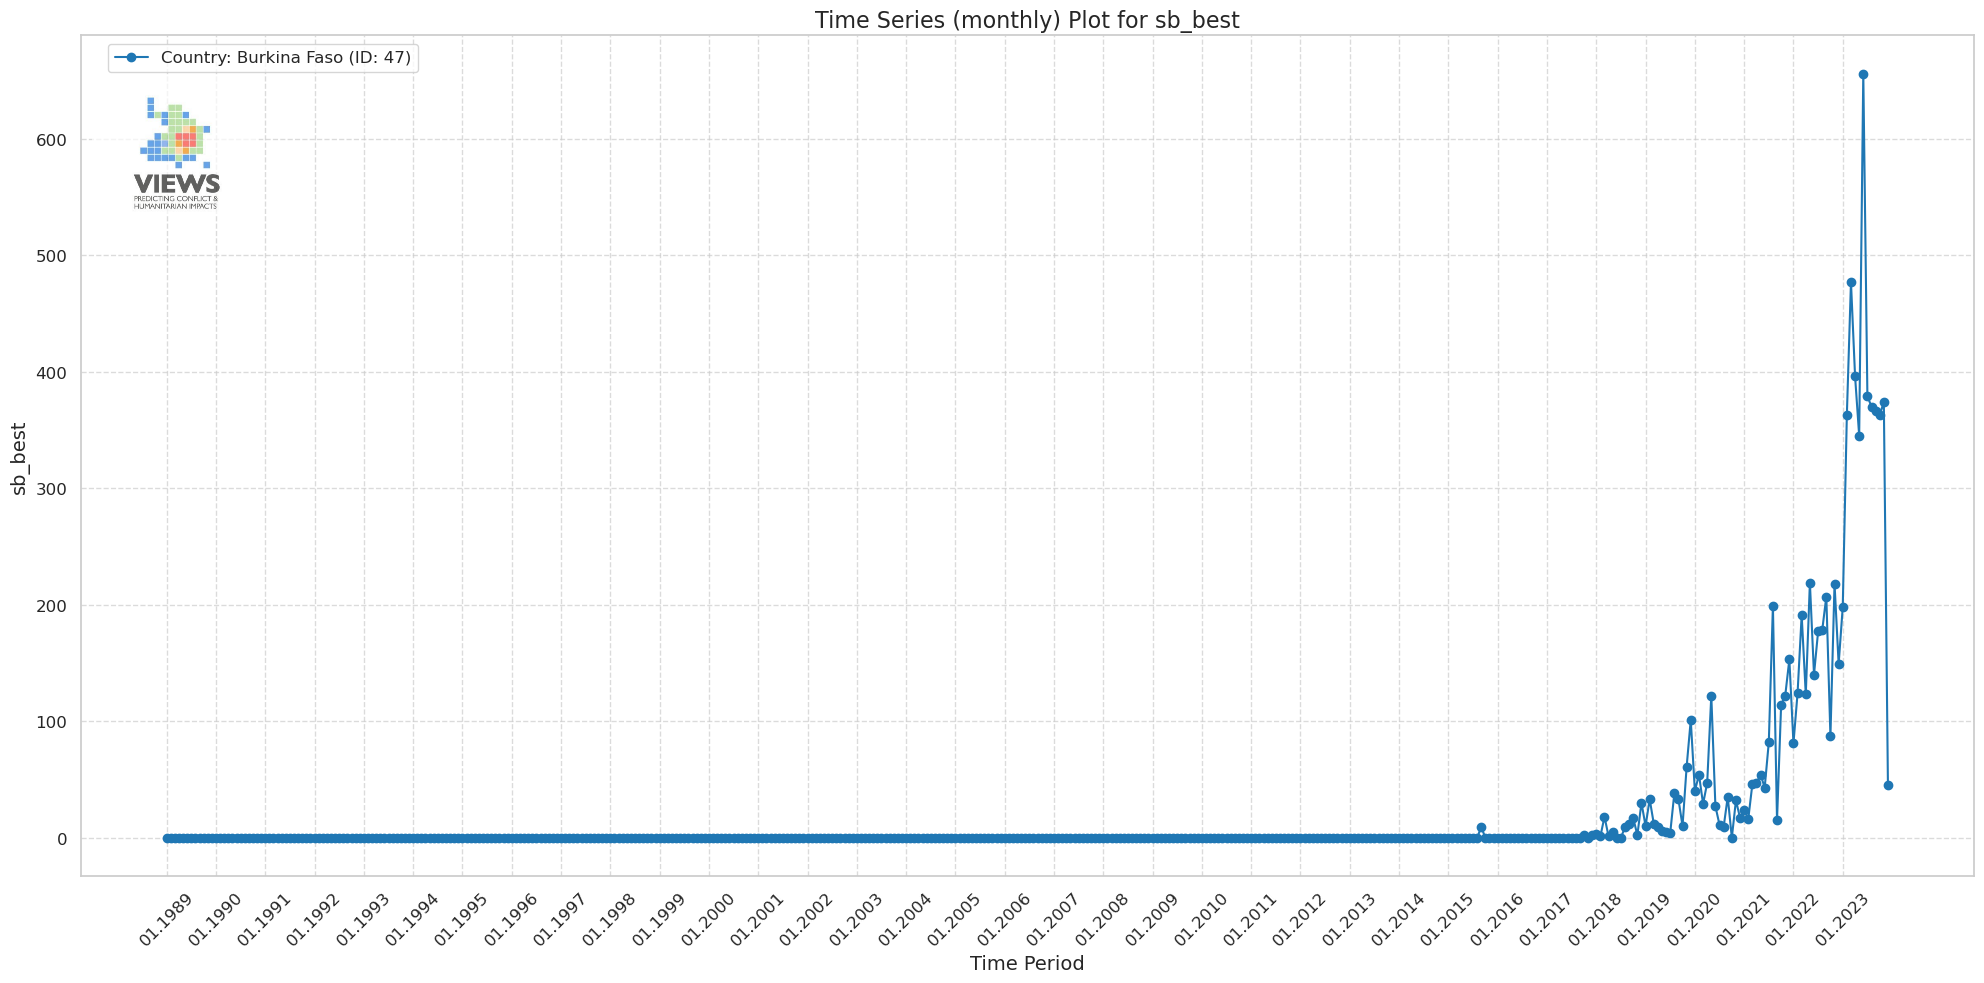

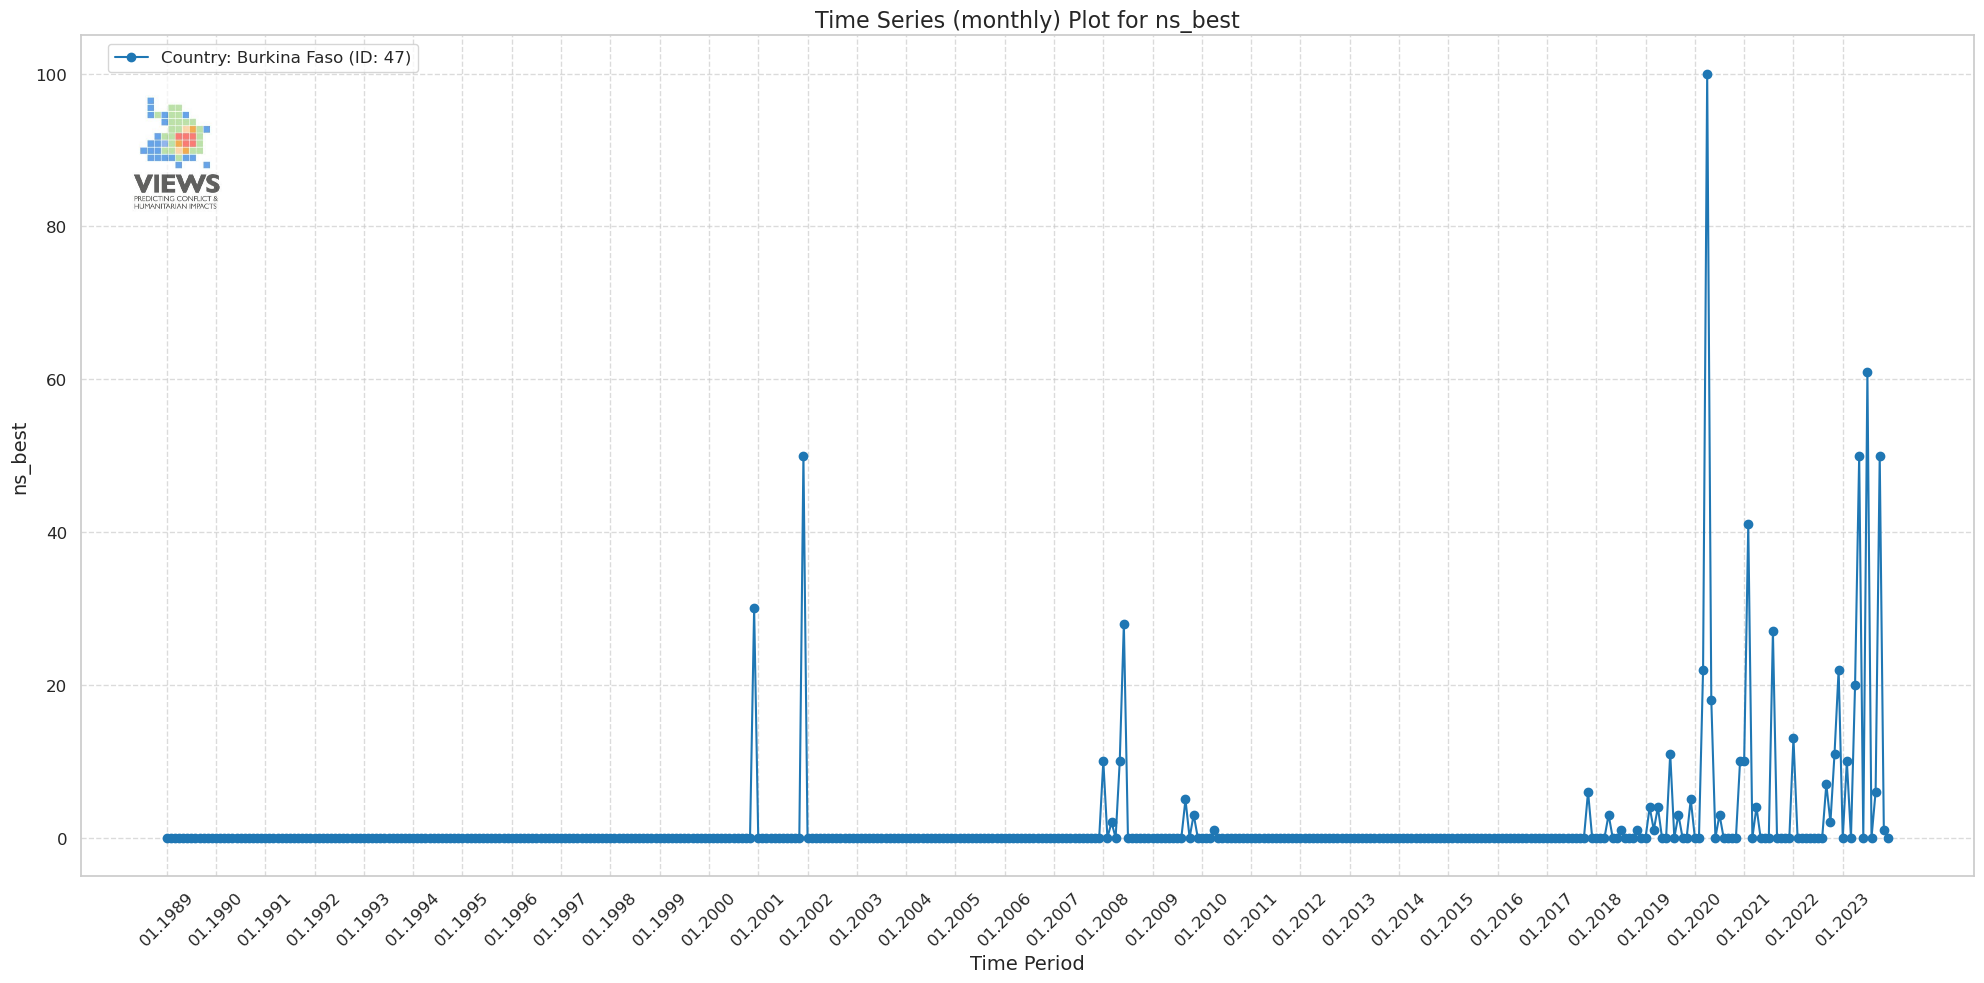

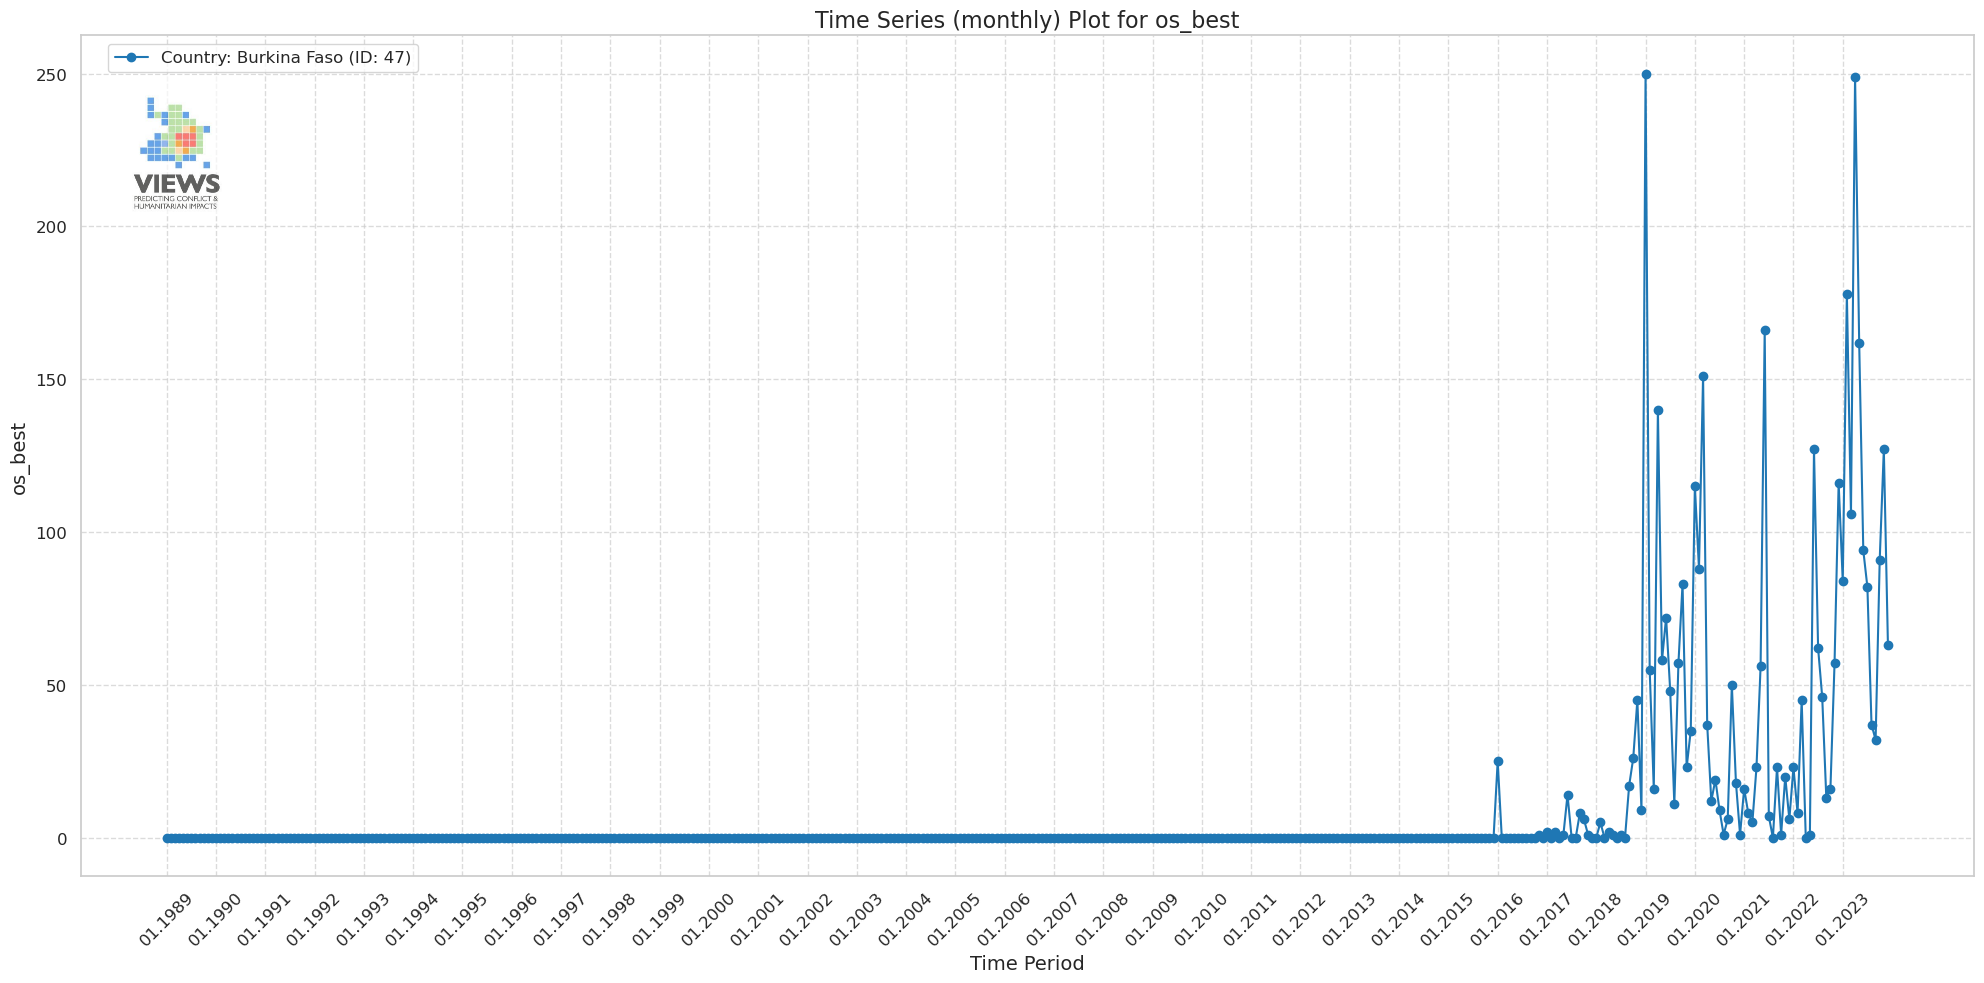

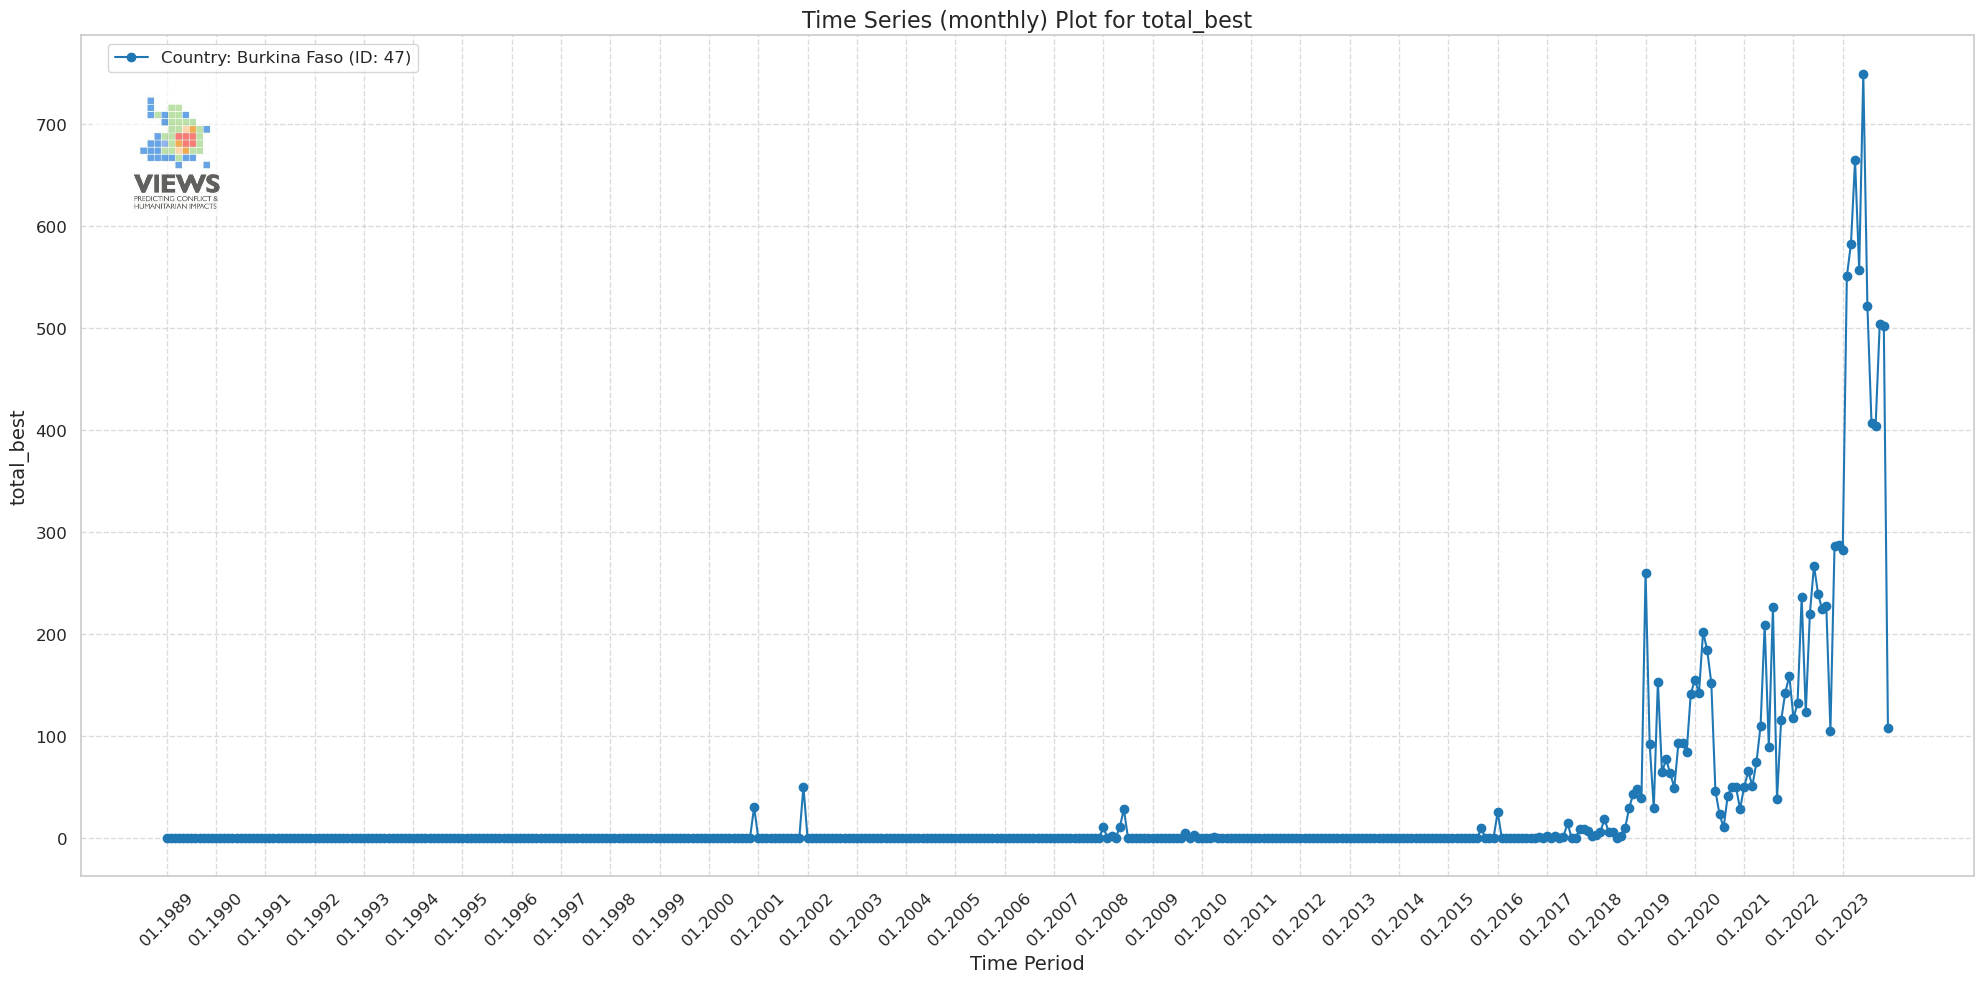

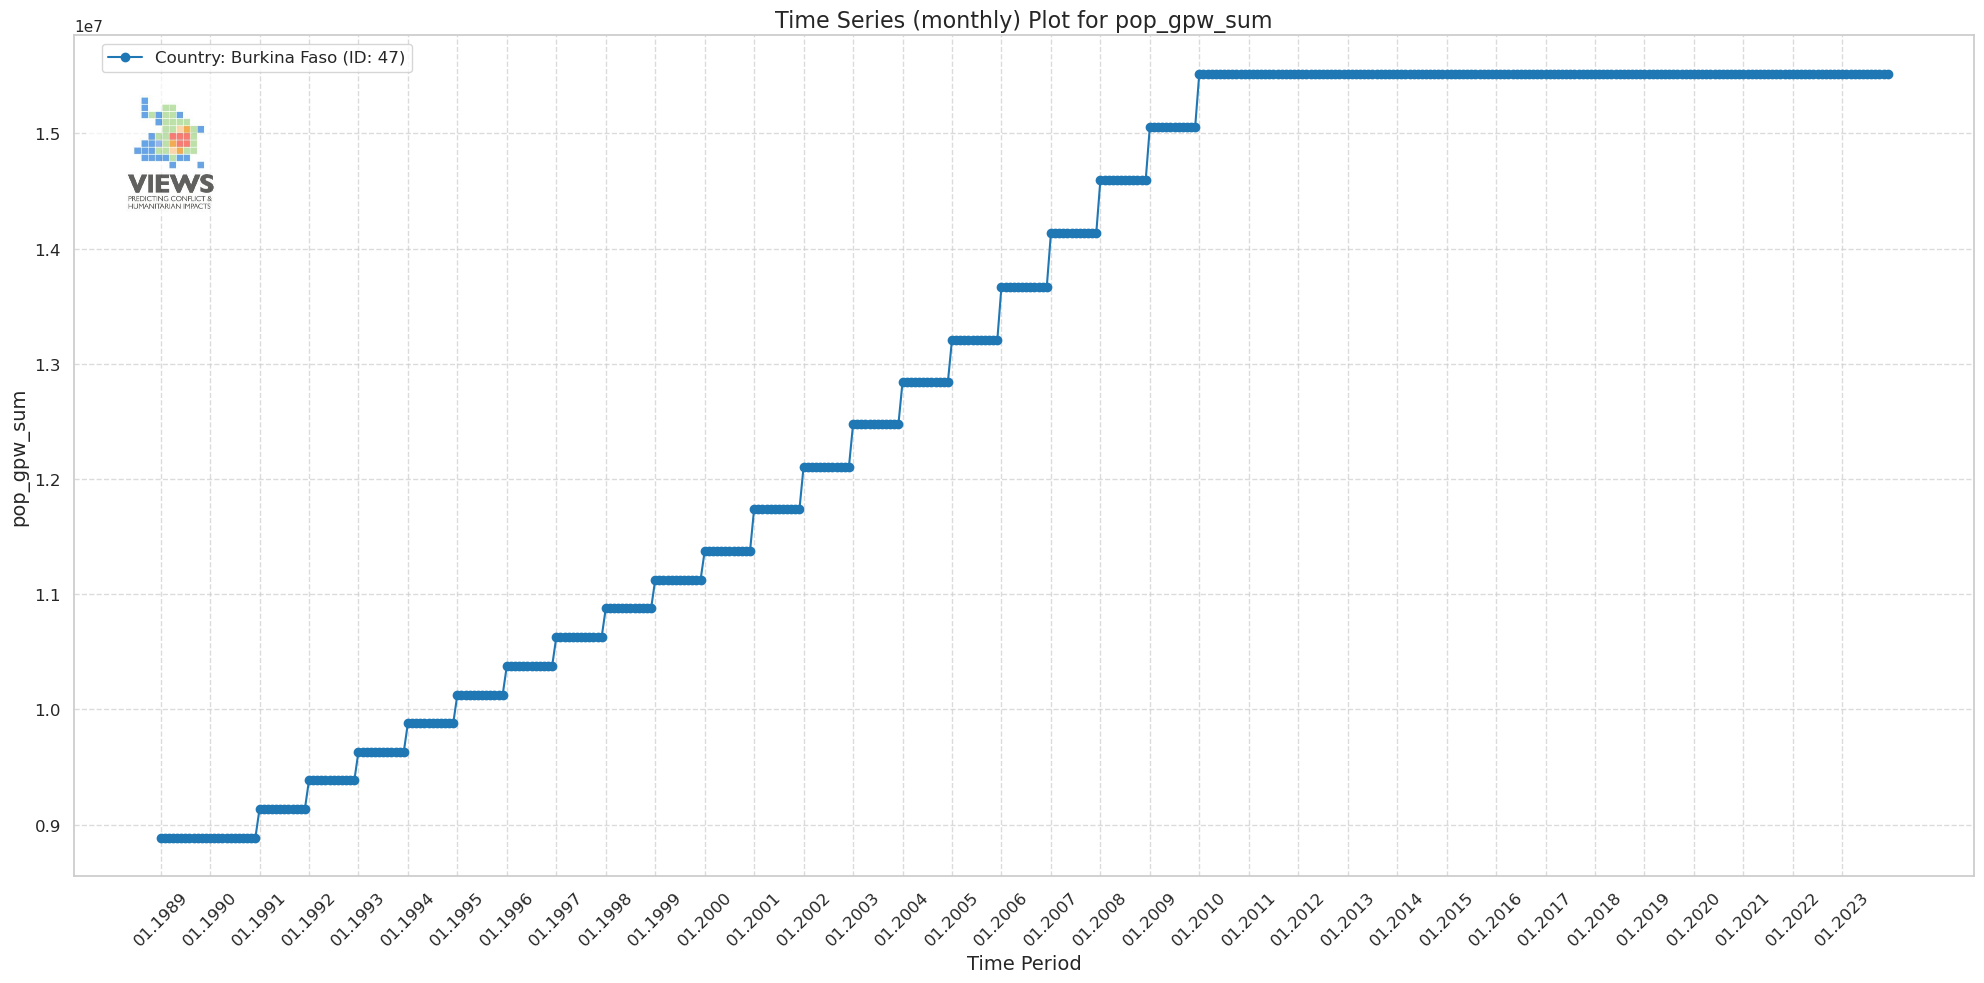

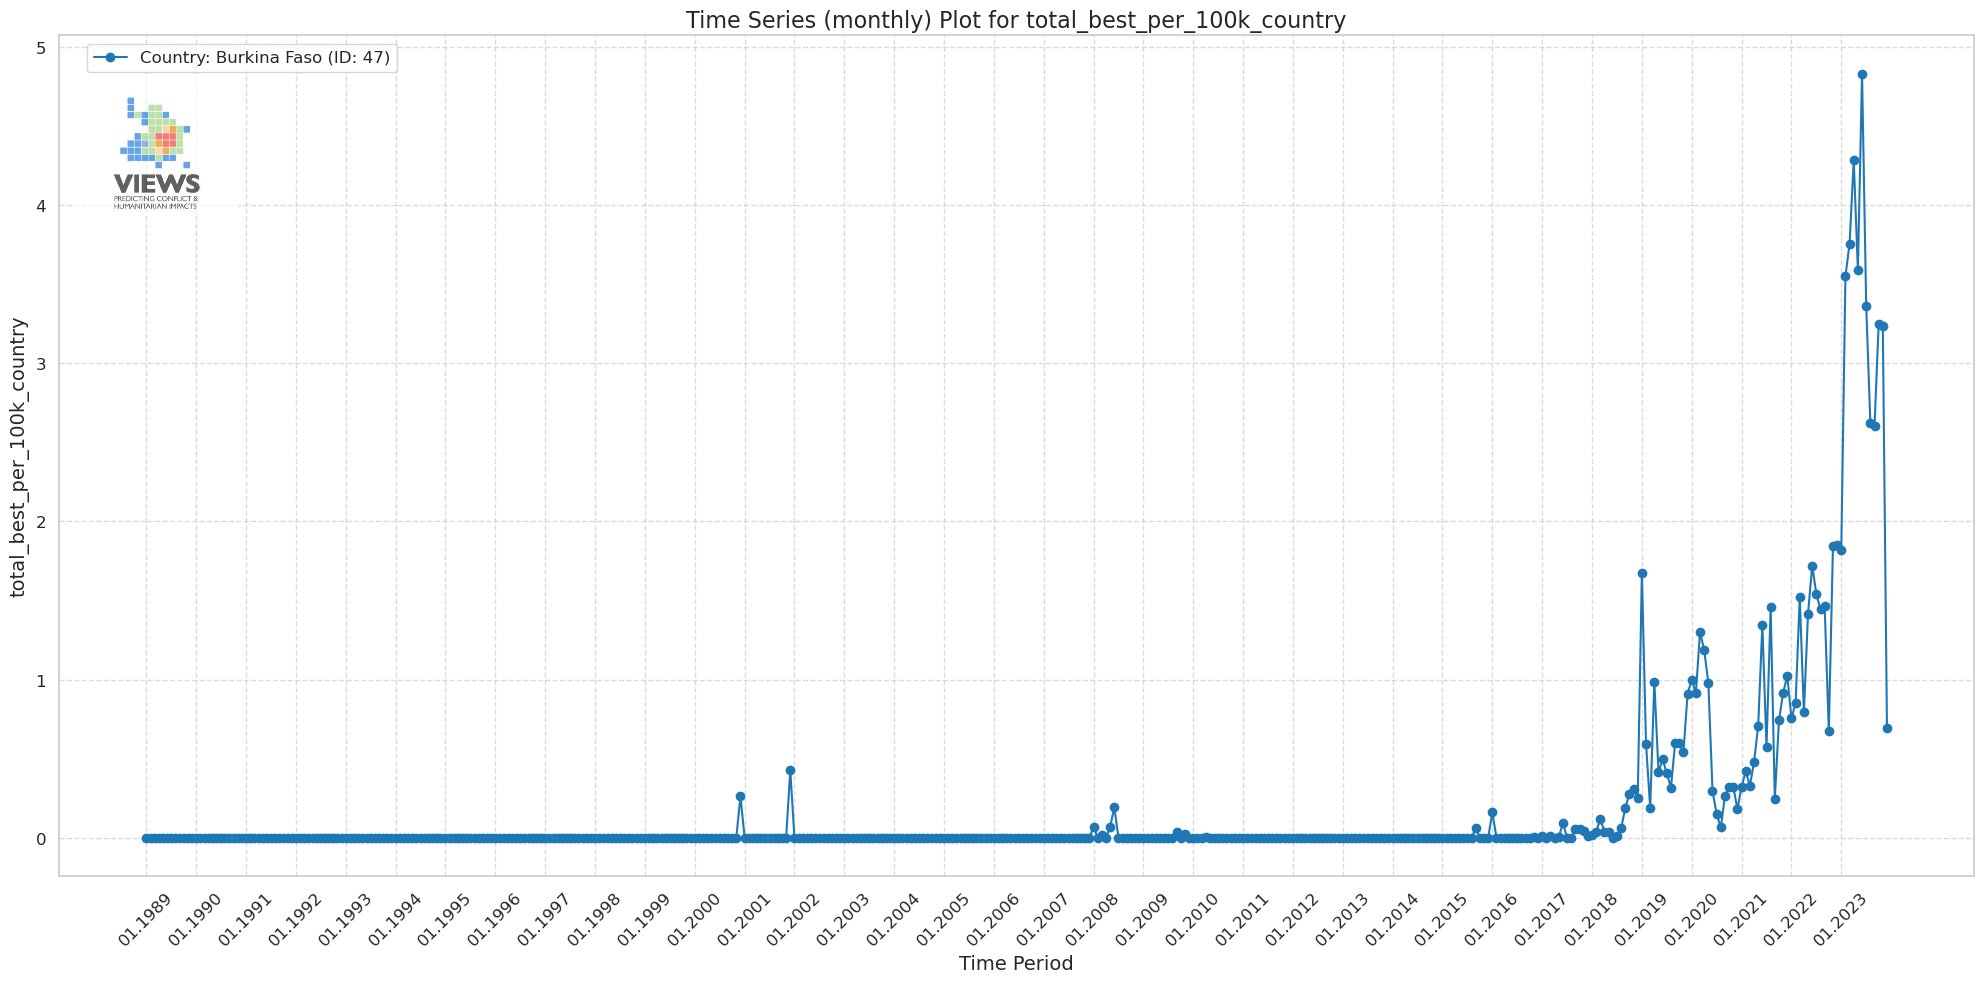

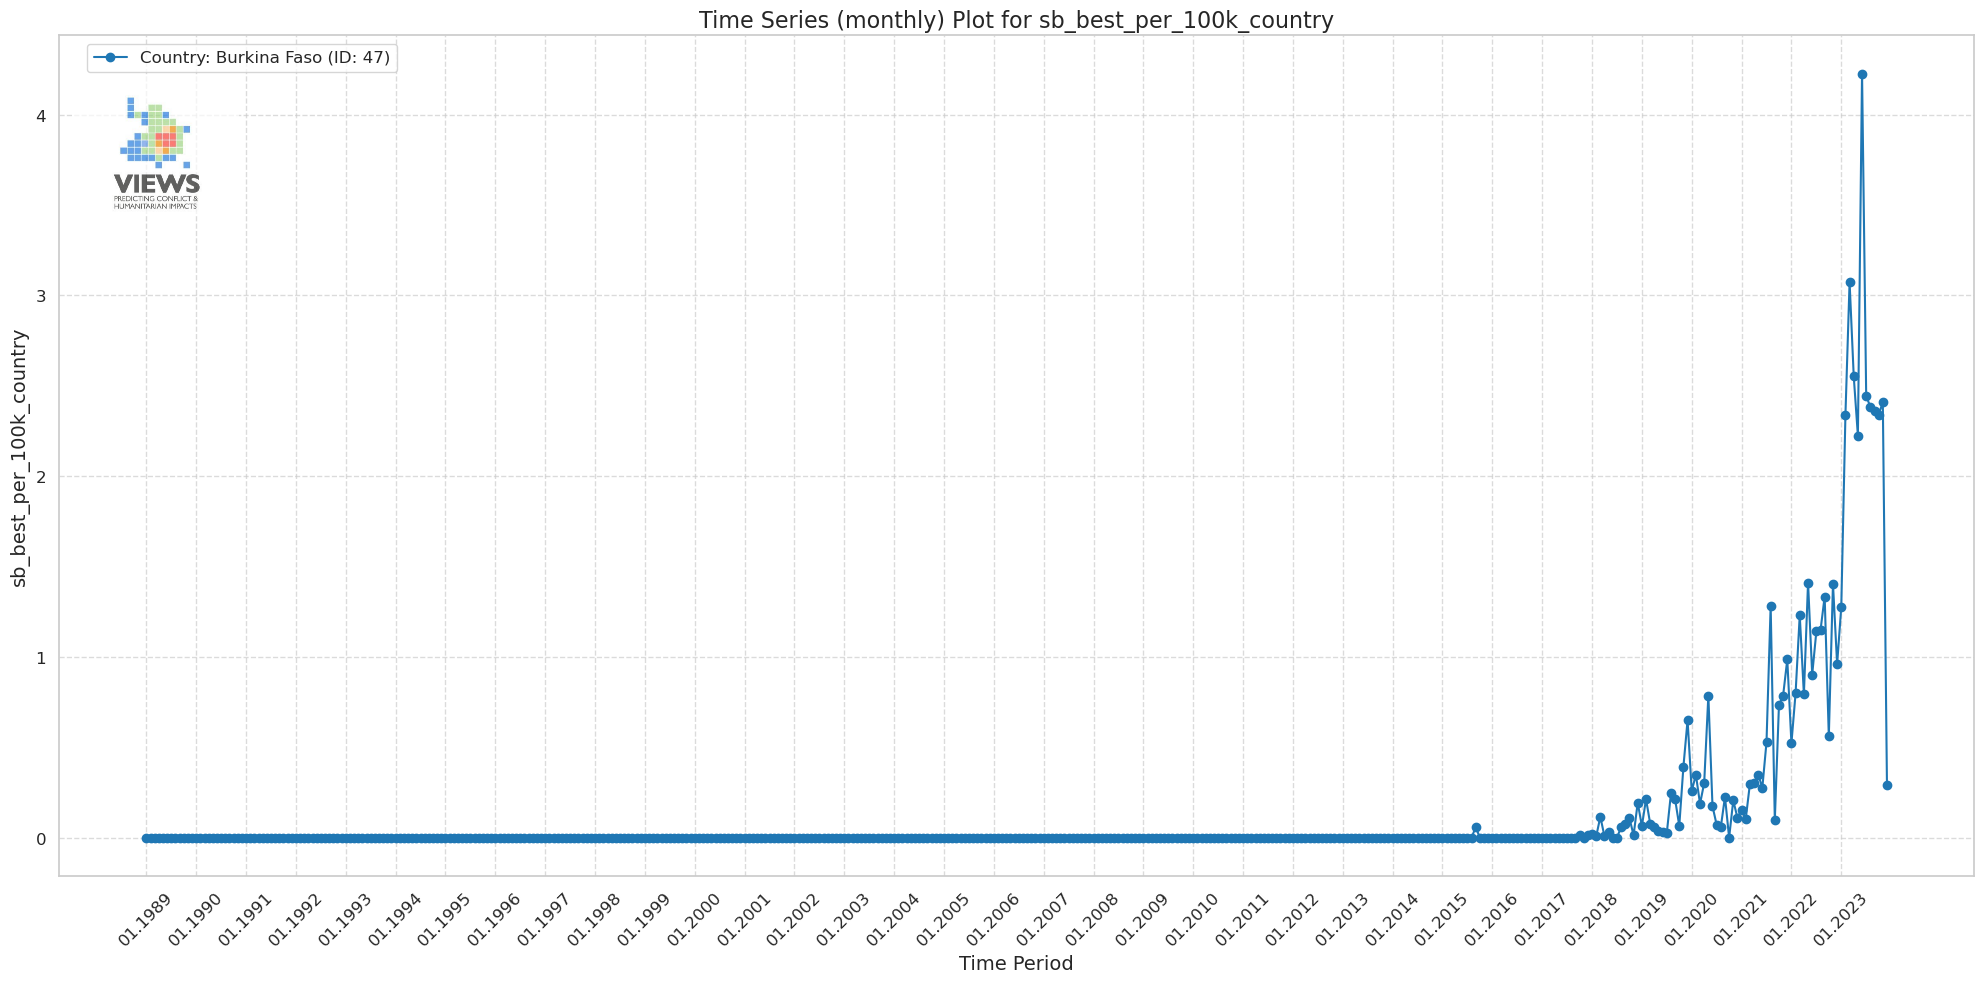

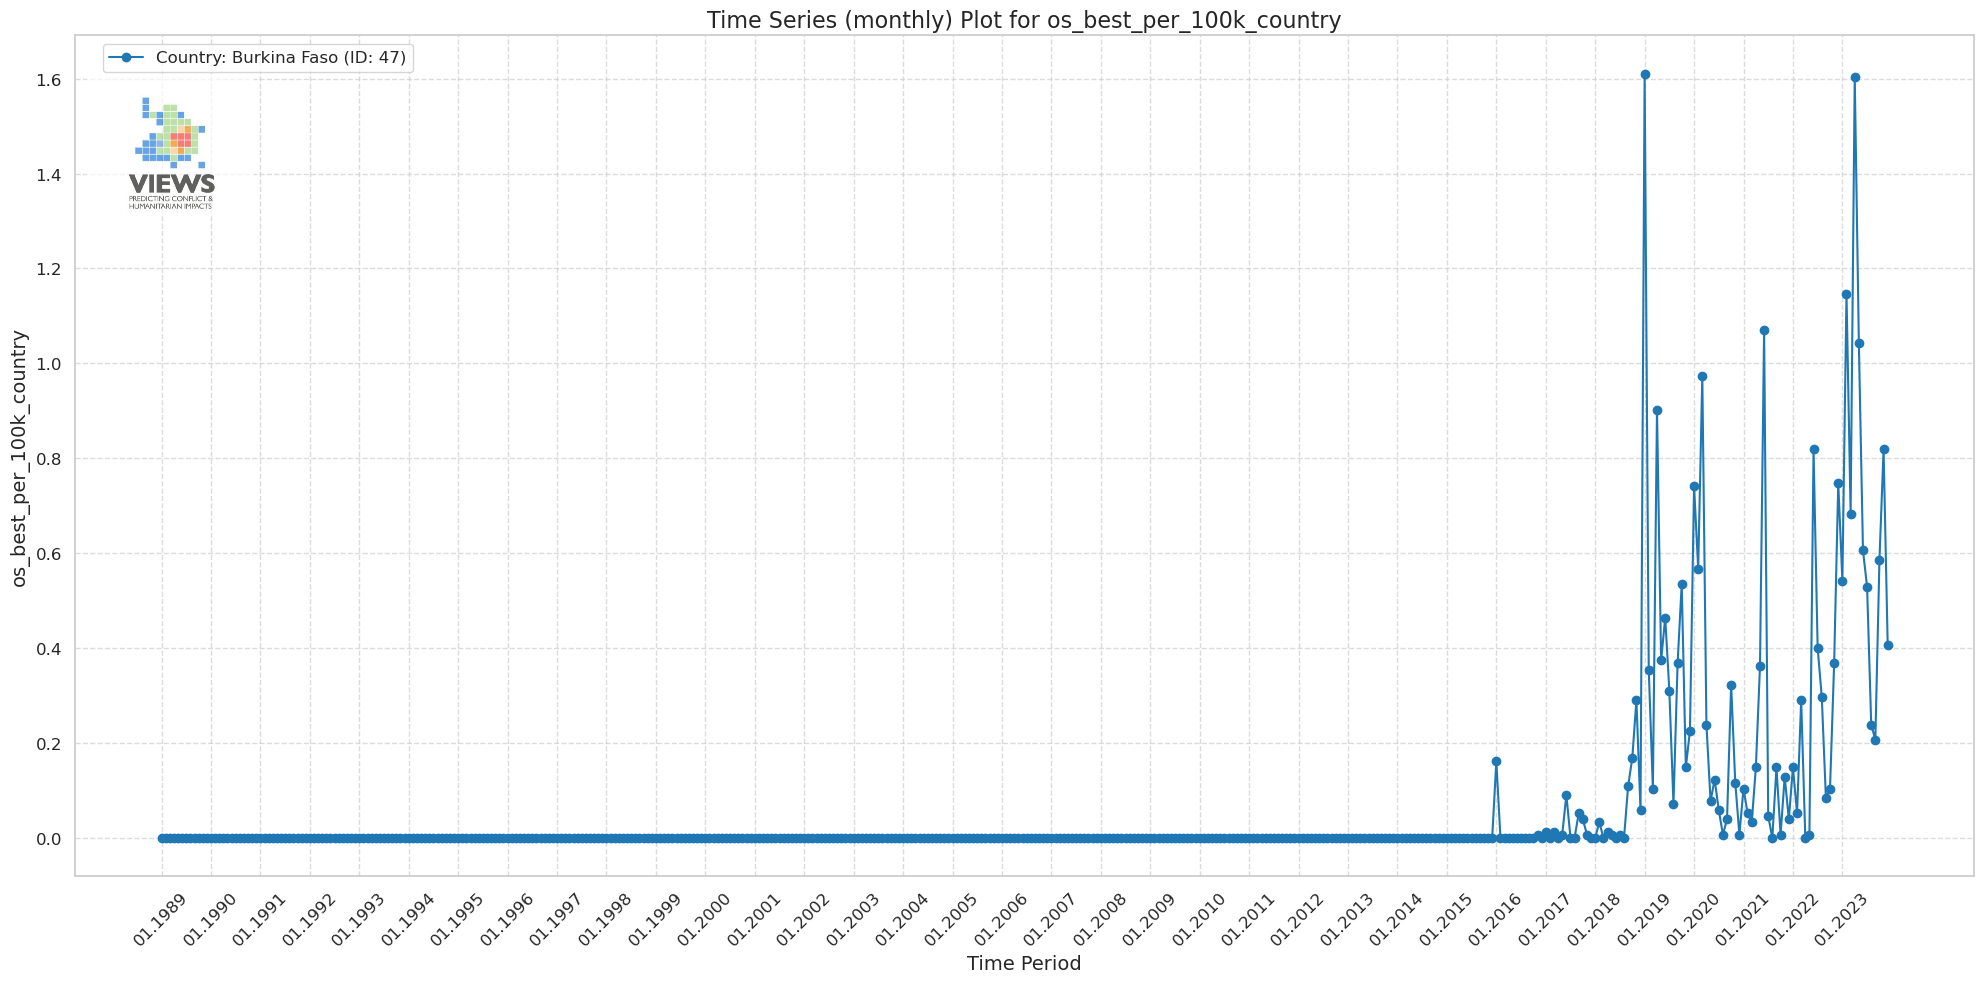

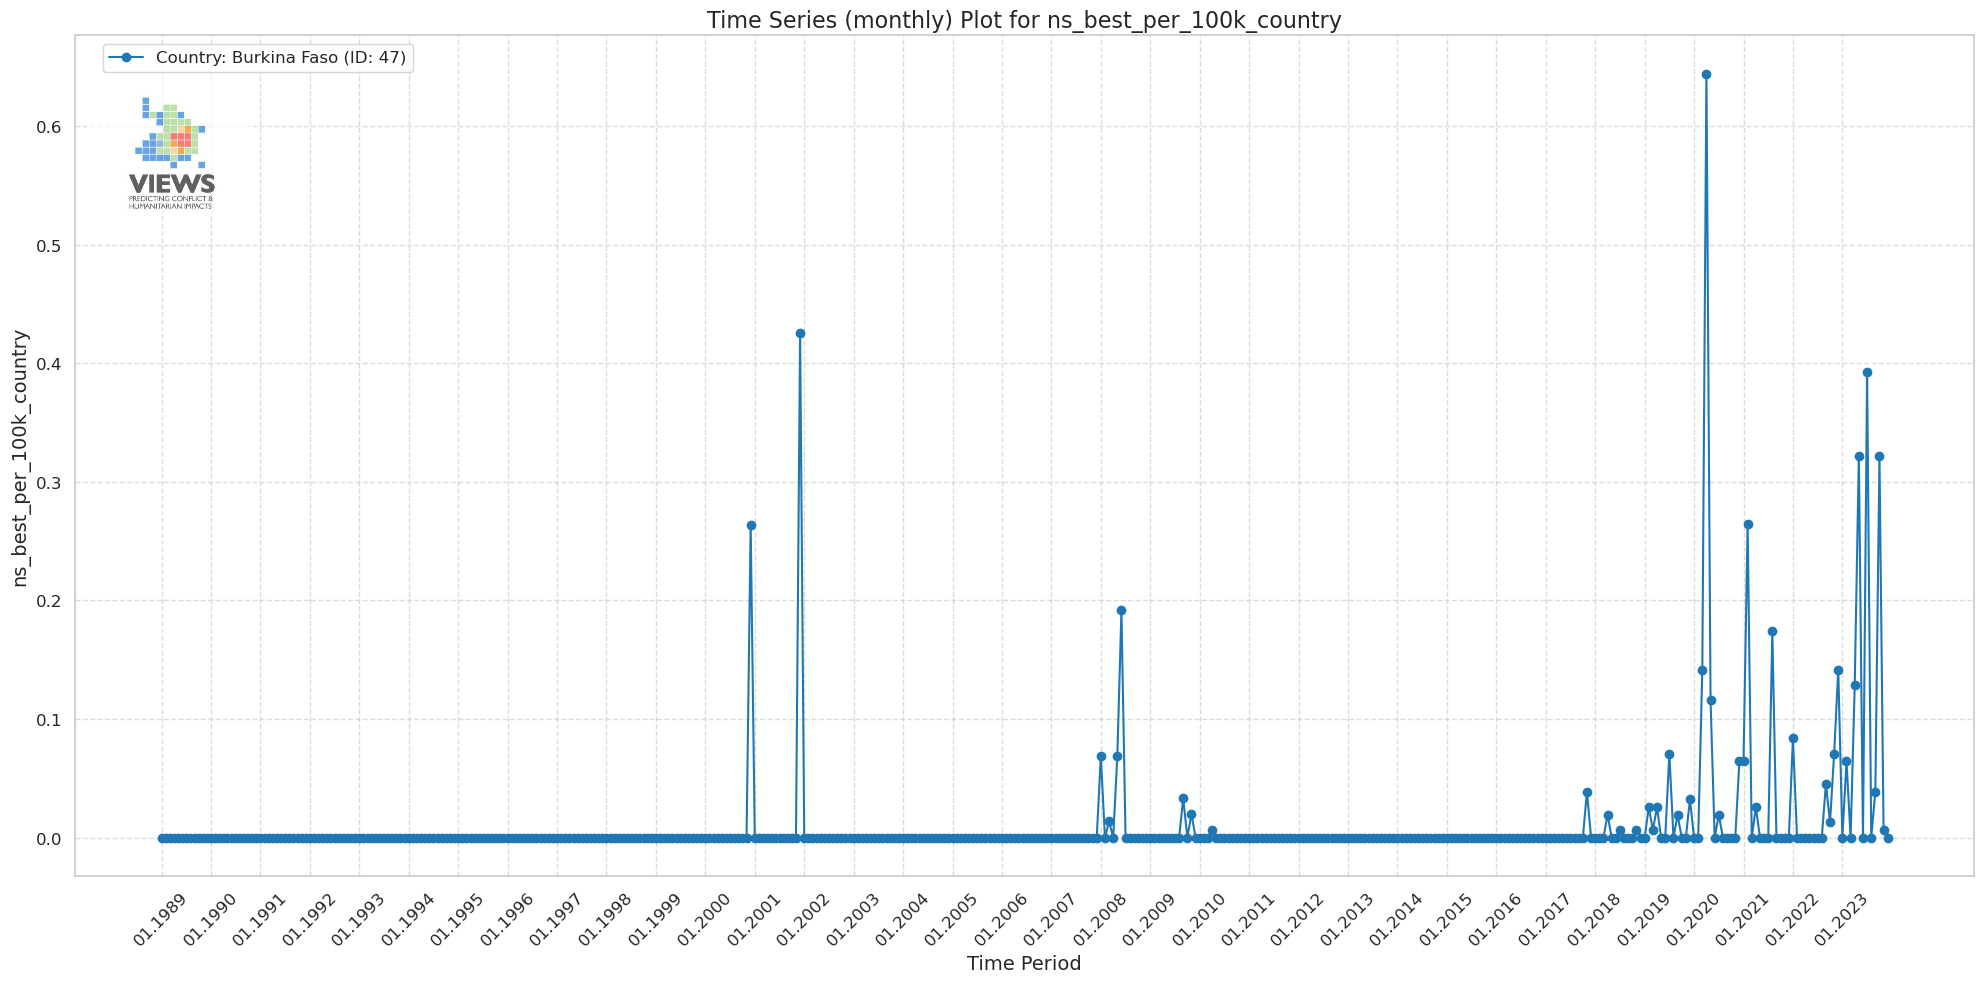

In [7]:
for feature in features:
    plot_country_time_series(df_monthly, [47], feature, figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

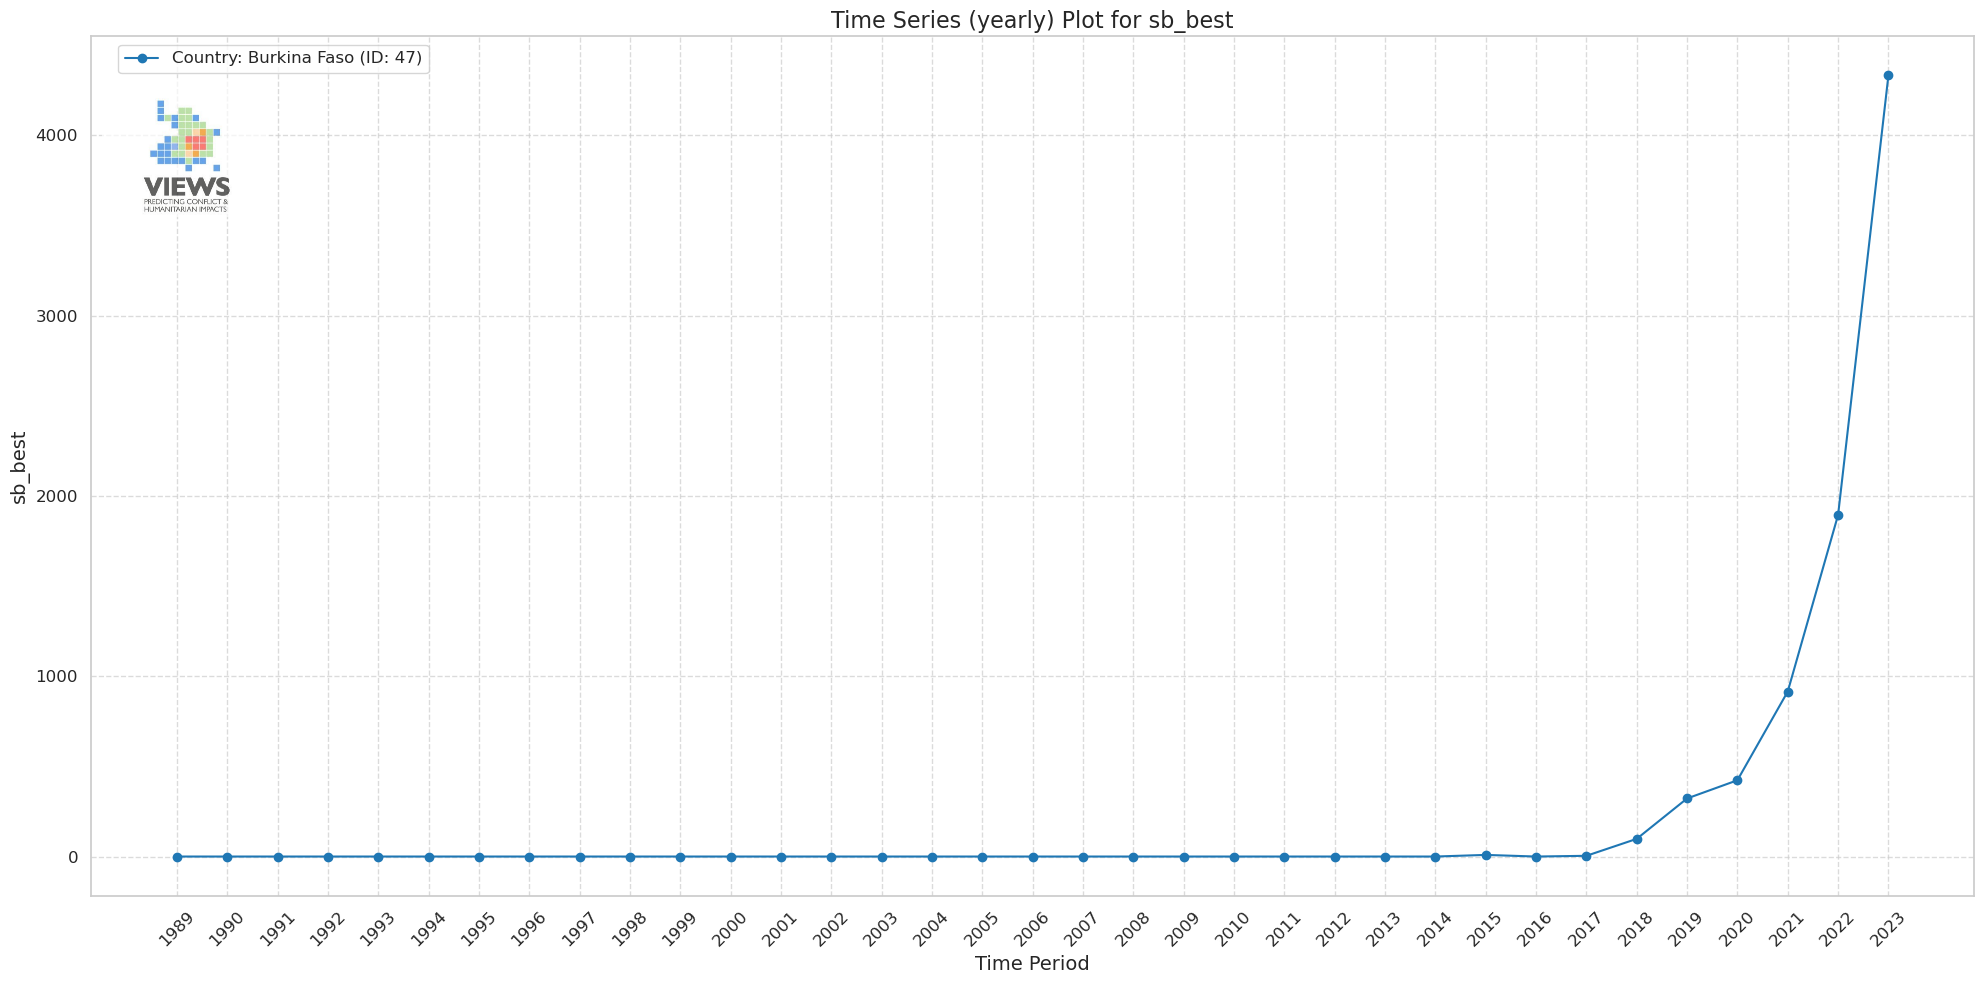

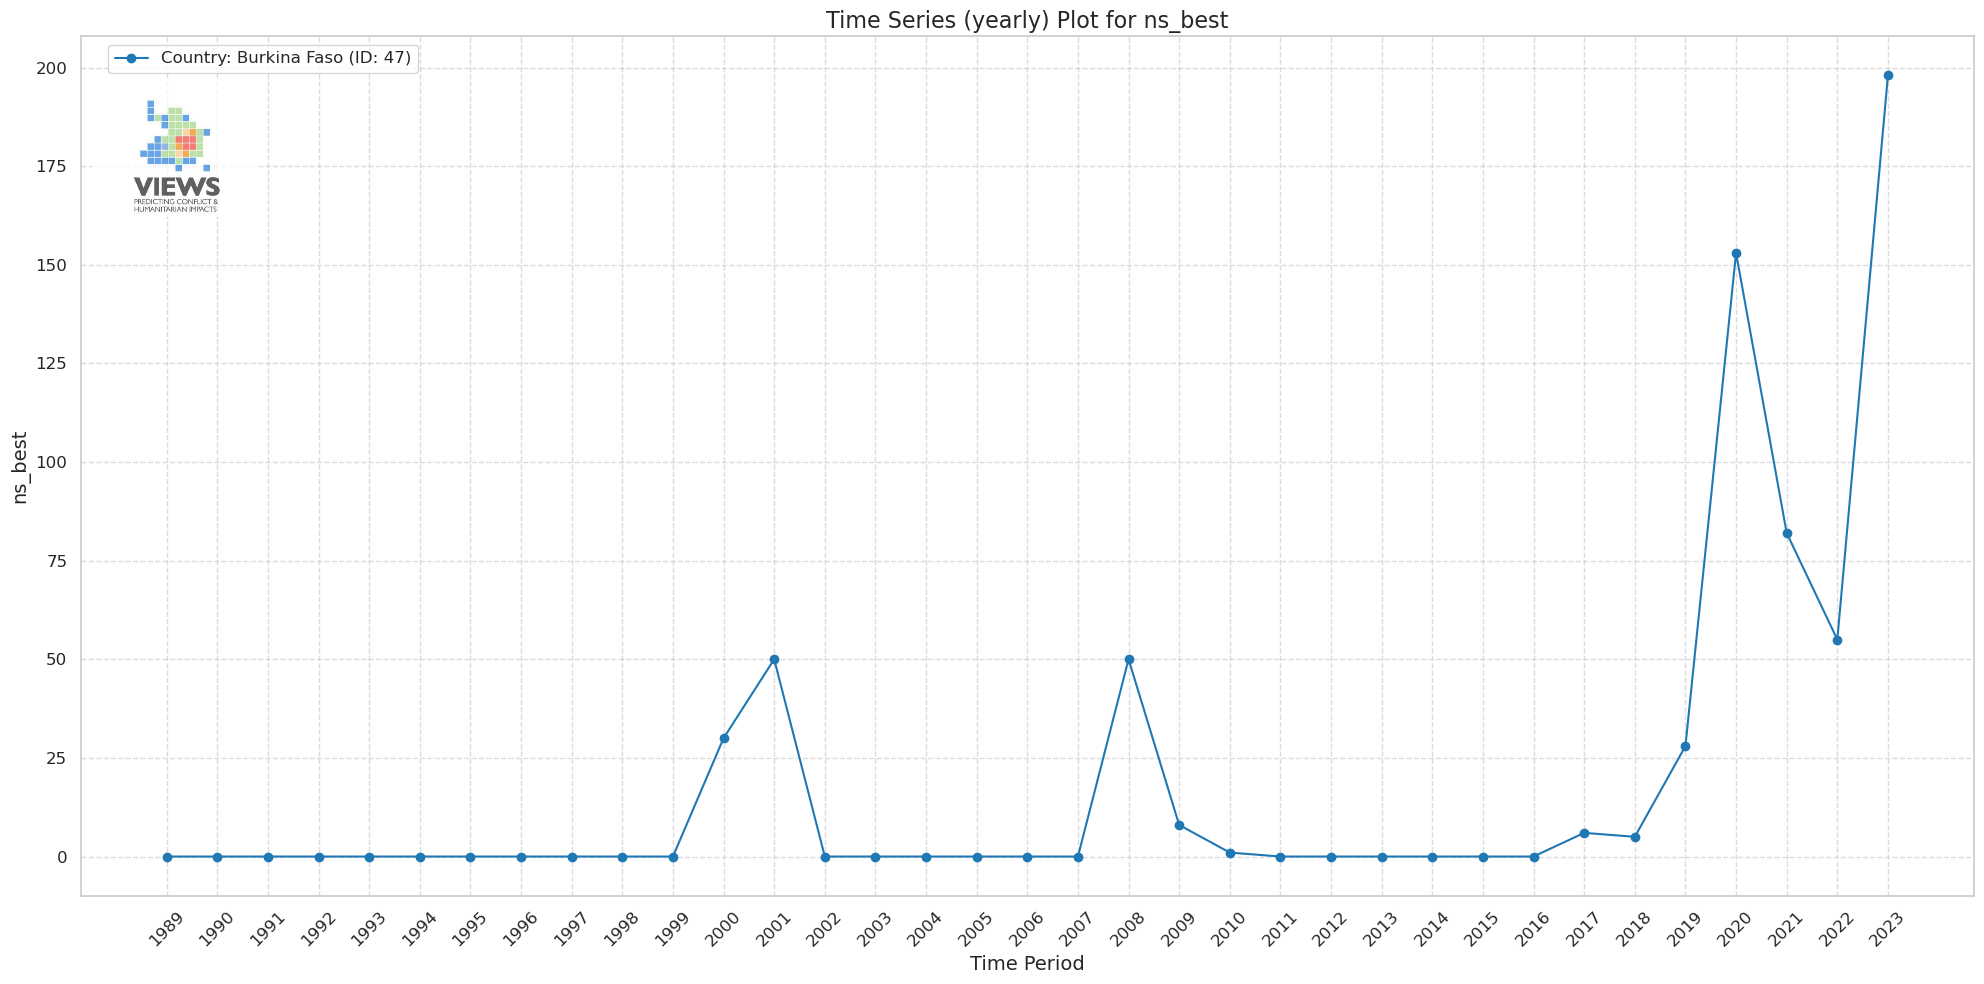

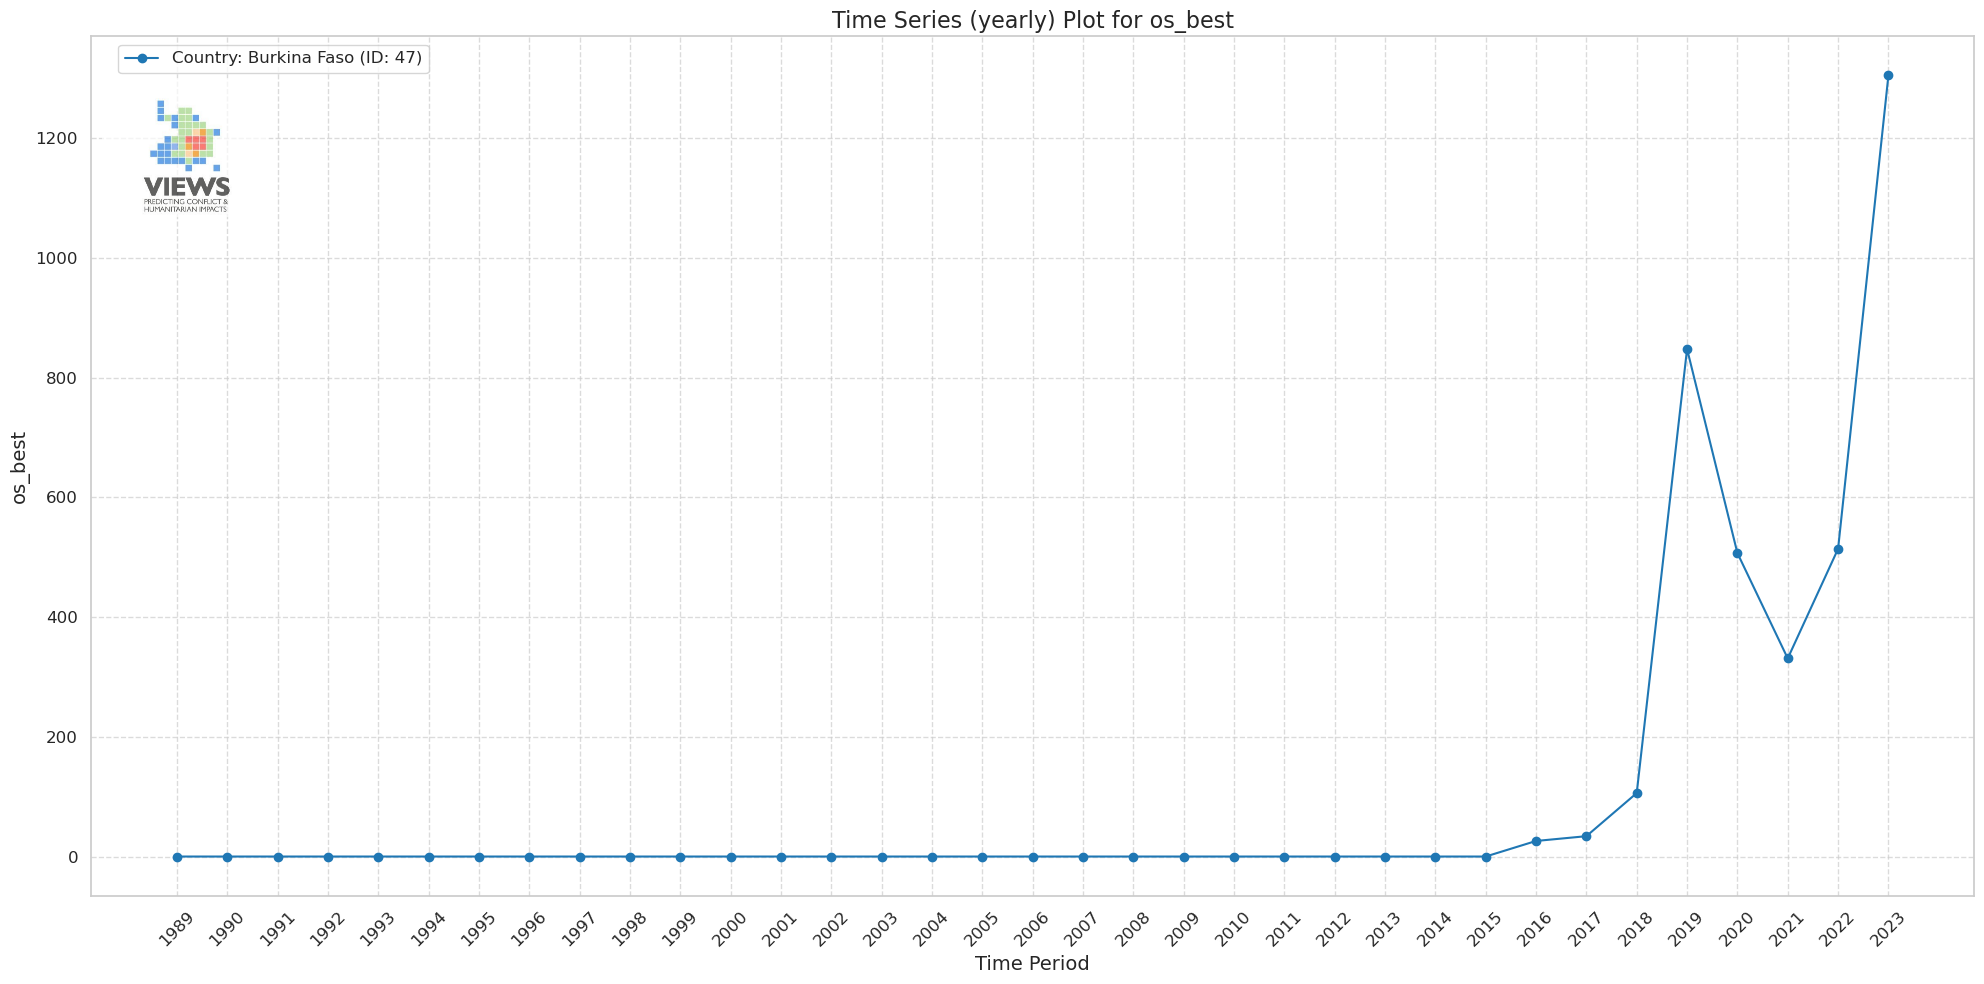

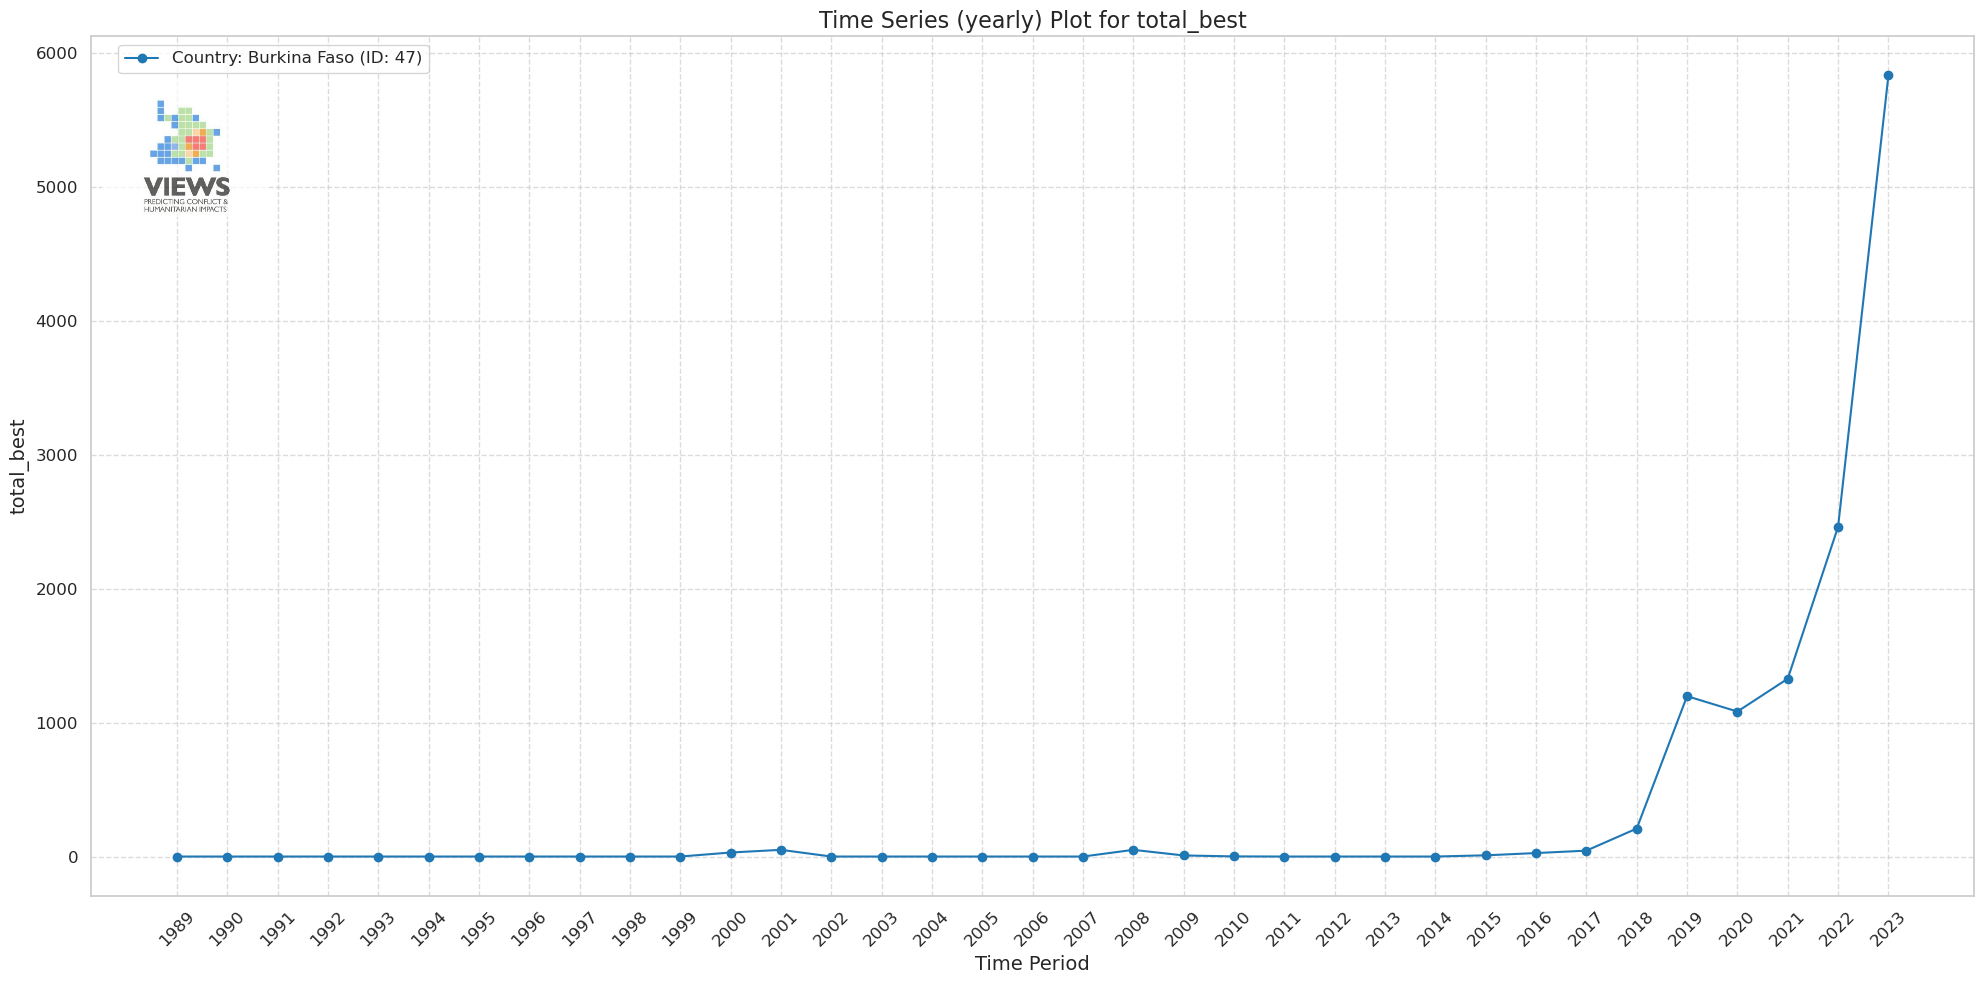

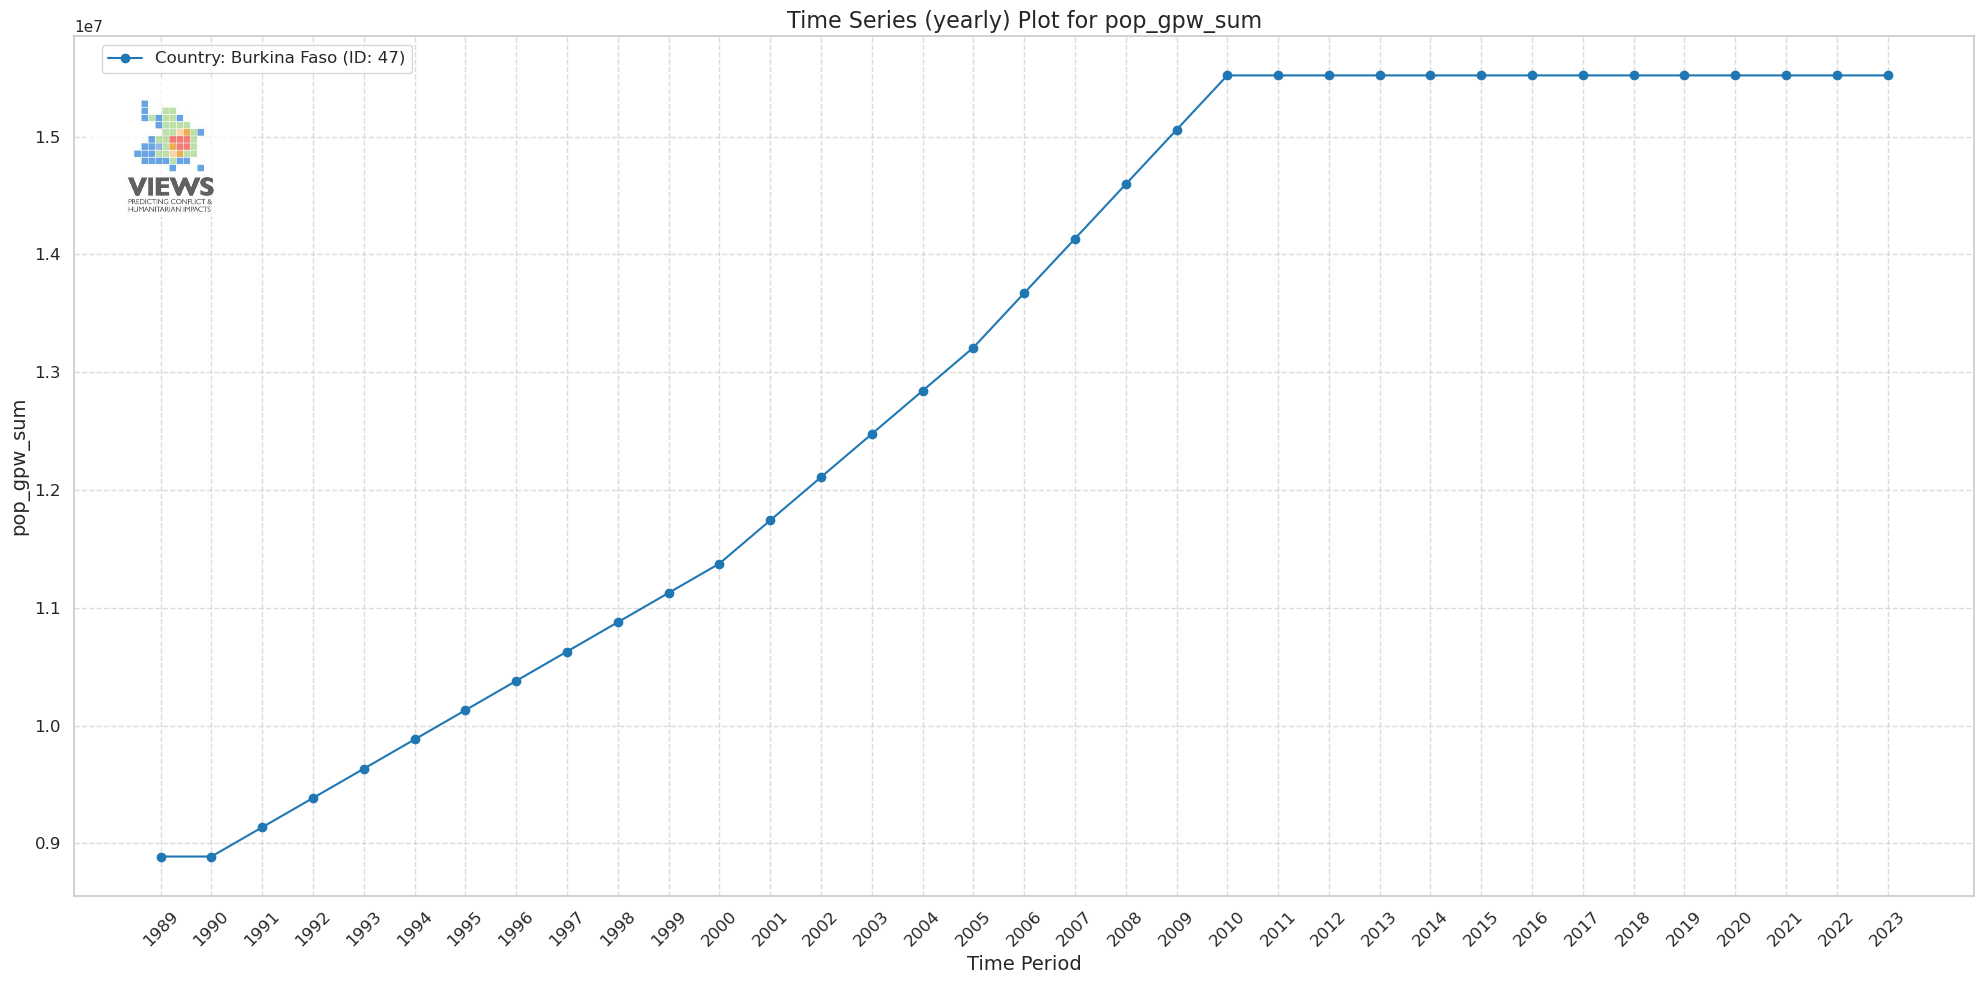

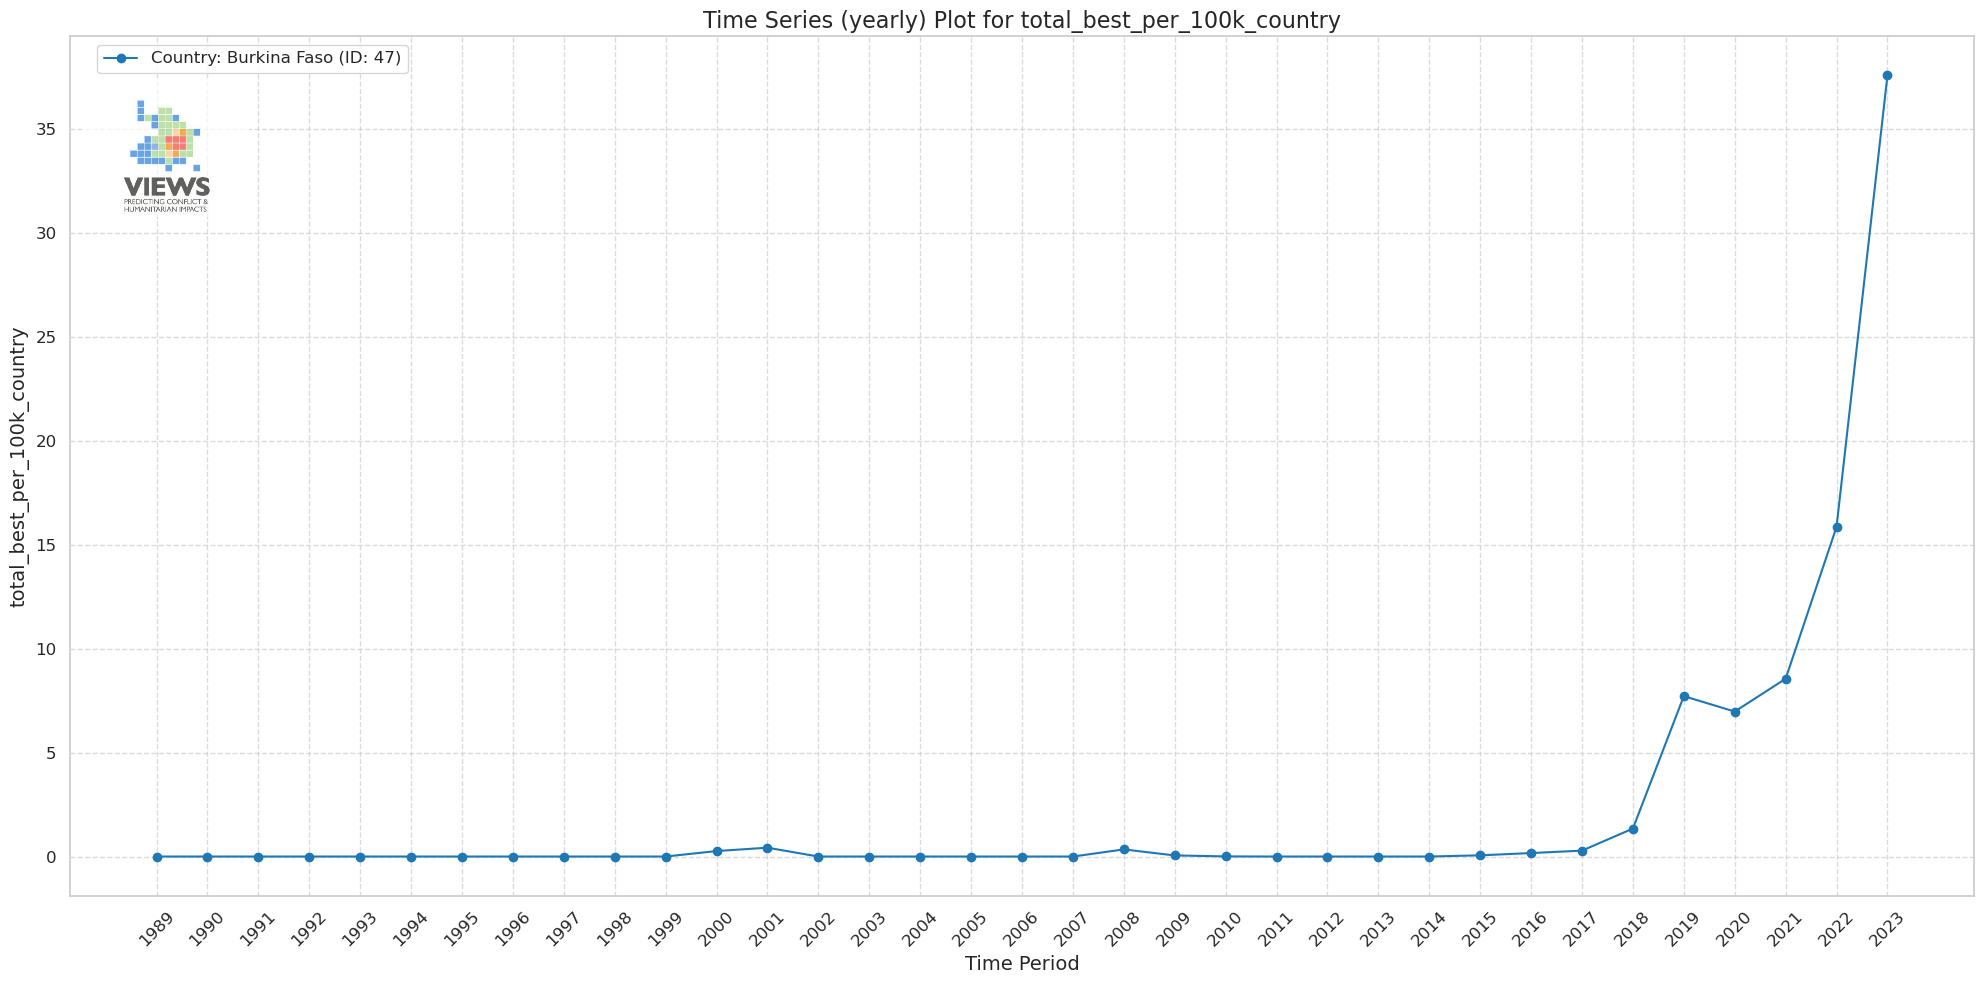

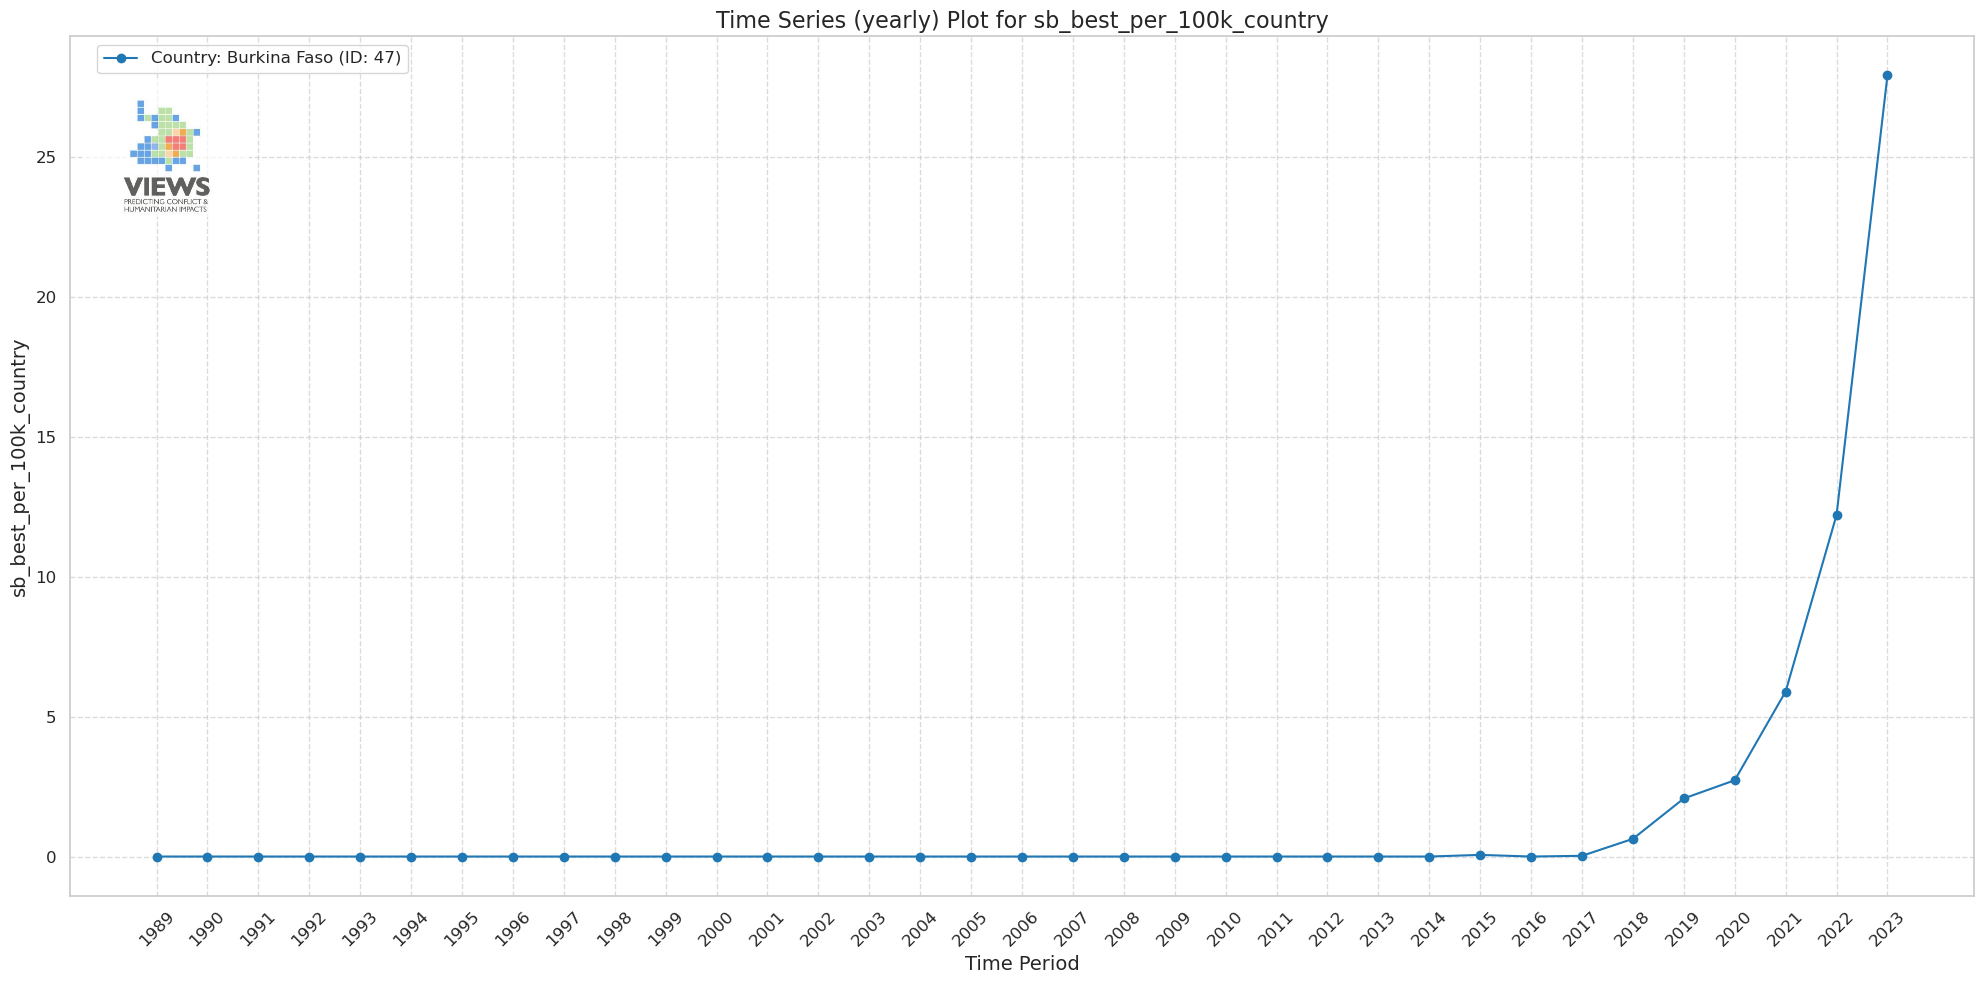

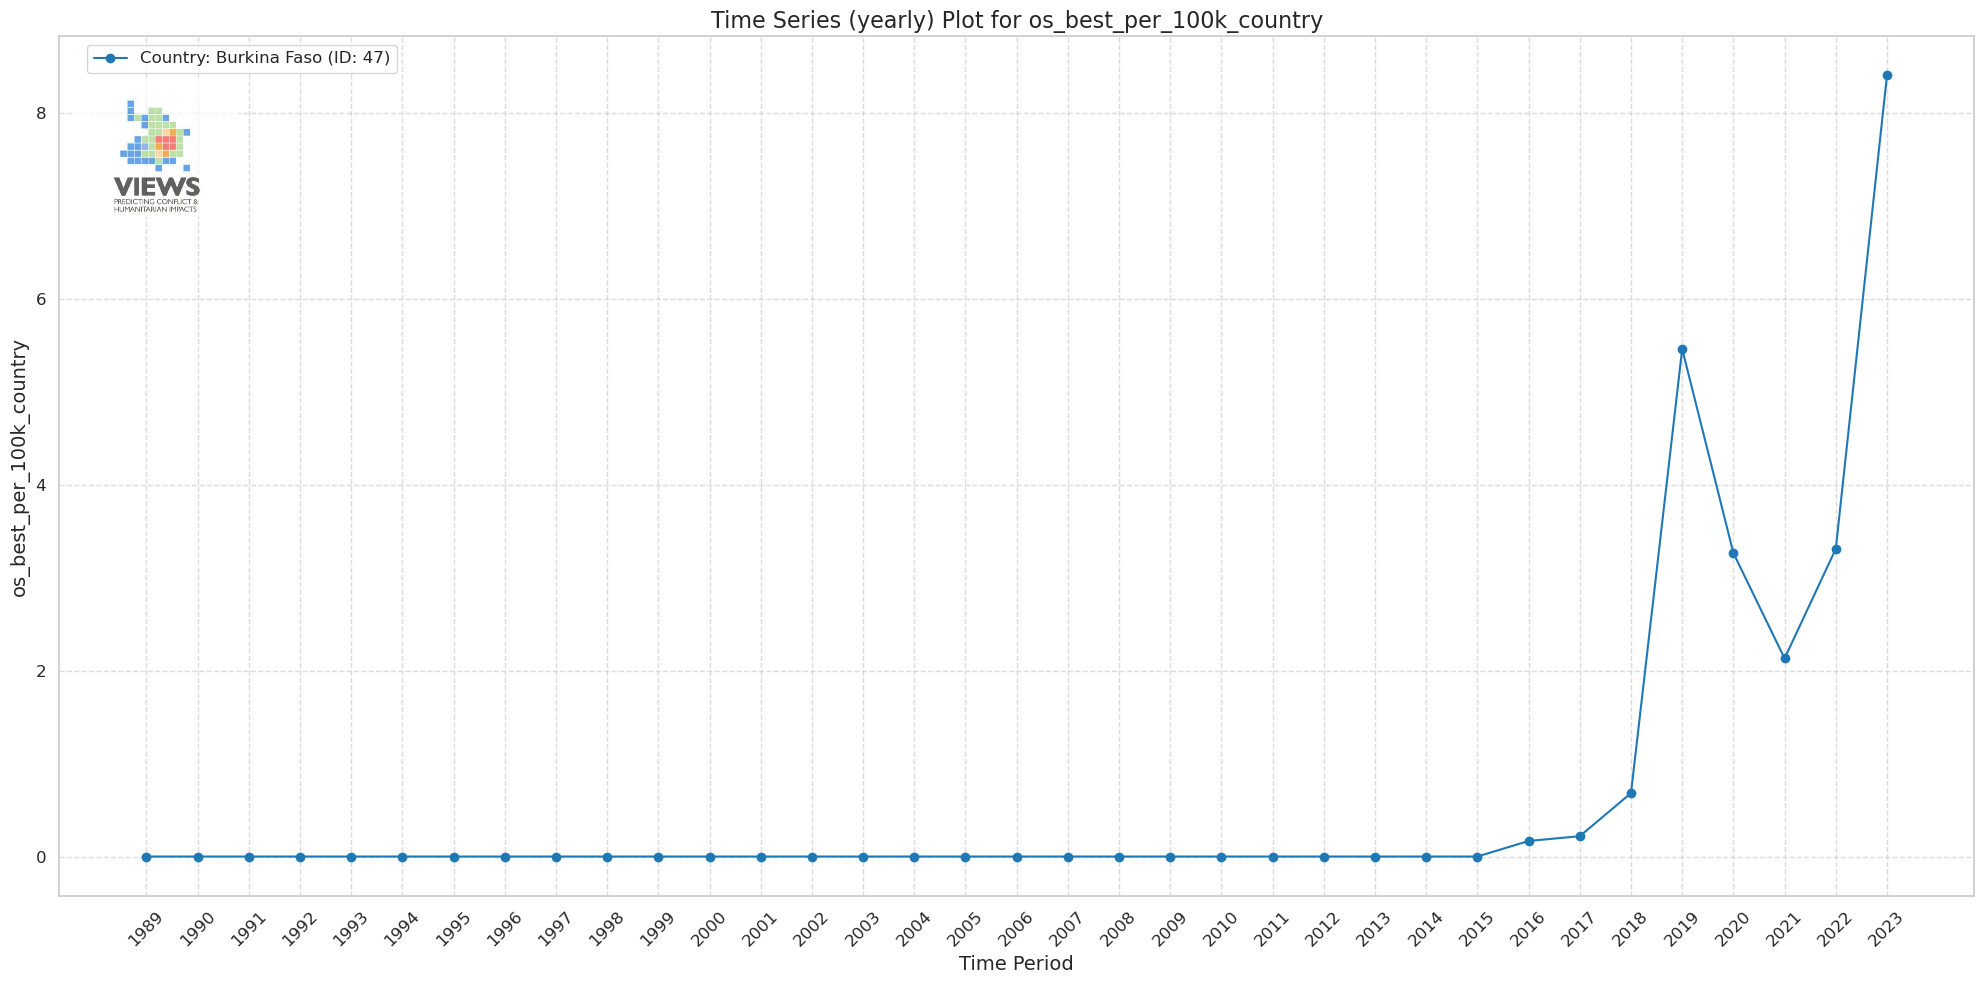

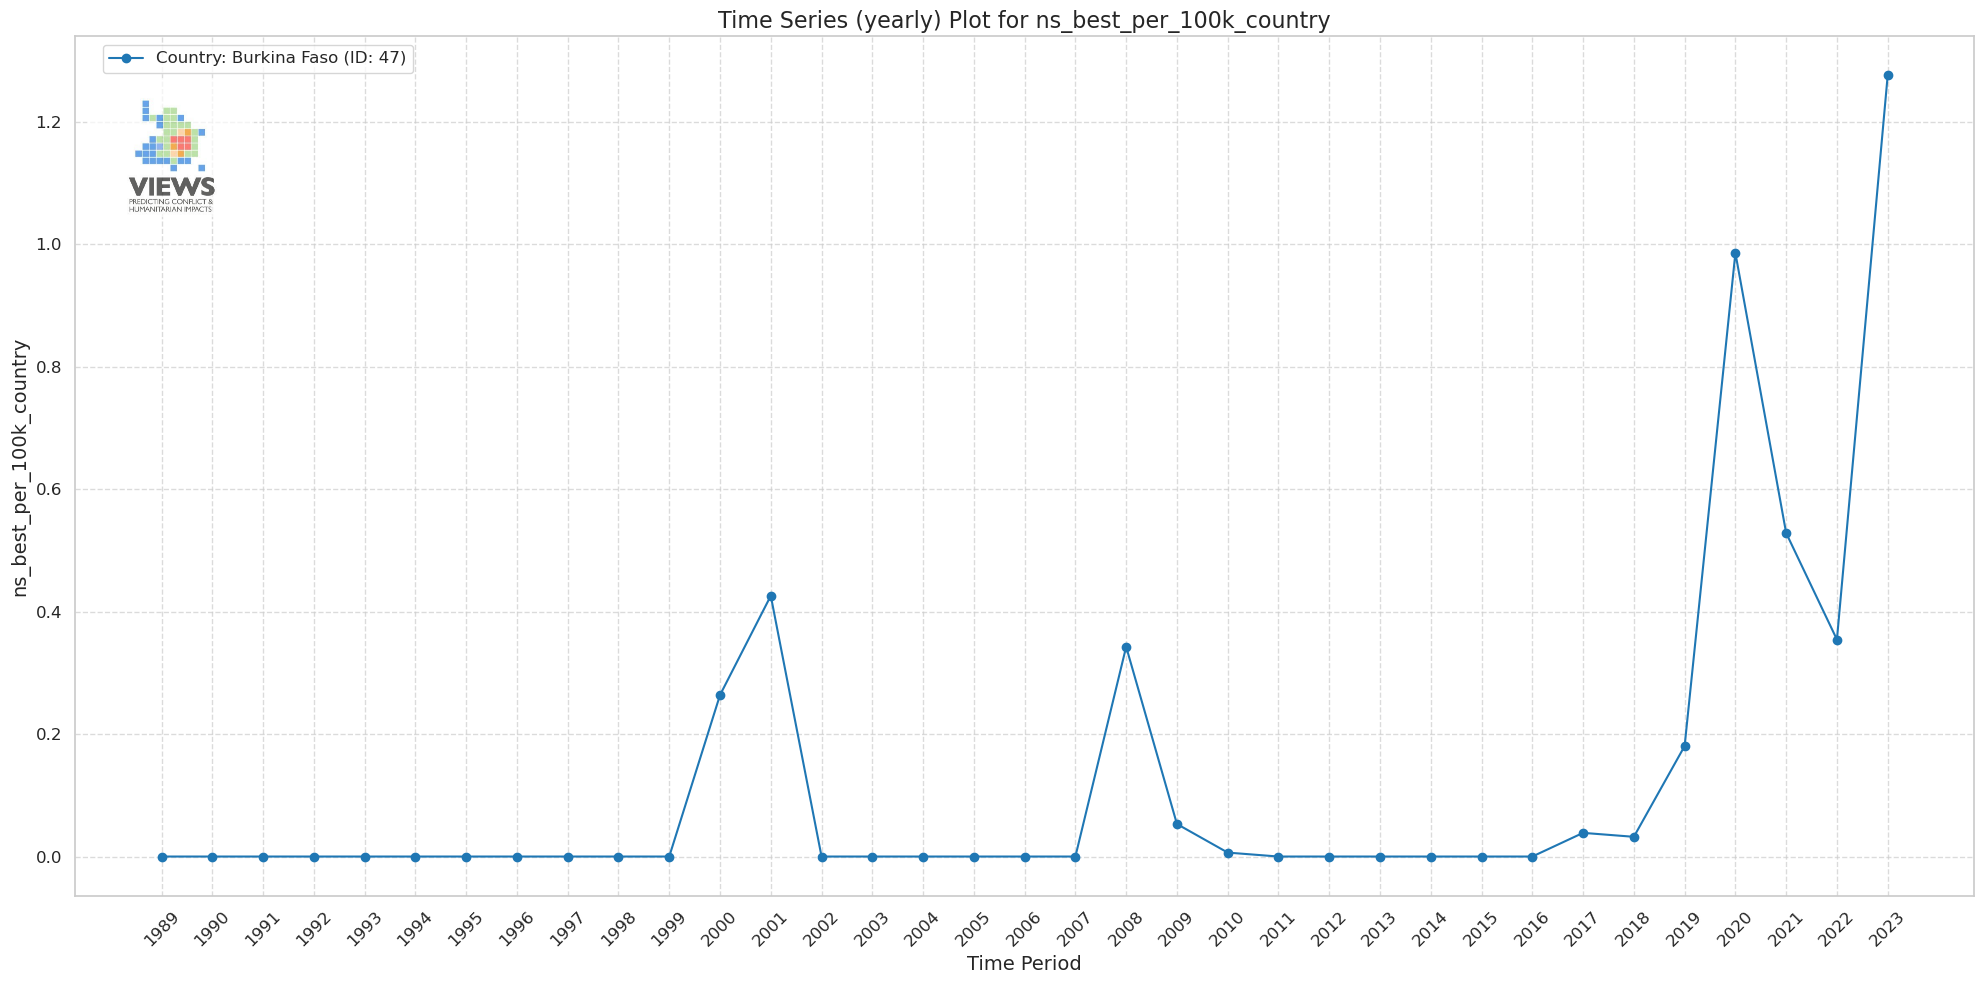

In [8]:
for feature in features:
    plot_country_time_series(df_yearly, [47], feature, figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [9]:
df_monthly, bin_list_monthly = process_binning(df_monthly)
df_yearly, bin_list_yearly = process_binning(df_yearly)

Processed feature 'sb_best_e_i' into 'sb_best_b_i' with bin types 'monthly_e_i'
Processed feature 'sb_best_e_i' into 'sb_best_b_i' with bin types 'monthly_e_i'
Processed feature 'sb_best_E_i' into 'sb_best_B_i' with bin types 'monthly_E_i'
Processed feature 'sb_best_E_i' into 'sb_best_B_i' with bin types 'monthly_E_i'
Processed feature 'ns_best_e_i' into 'ns_best_b_i' with bin types 'monthly_e_i'
Processed feature 'ns_best_e_i' into 'ns_best_b_i' with bin types 'monthly_e_i'
Processed feature 'ns_best_E_i' into 'ns_best_B_i' with bin types 'monthly_E_i'
Processed feature 'ns_best_E_i' into 'ns_best_B_i' with bin types 'monthly_E_i'
Processed feature 'os_best_e_i' into 'os_best_b_i' with bin types 'monthly_e_i'
Processed feature 'os_best_e_i' into 'os_best_b_i' with bin types 'monthly_e_i'
Processed feature 'os_best_E_i' into 'os_best_B_i' with bin types 'monthly_E_i'
Processed feature 'os_best_E_i' into 'os_best_B_i' with bin types 'monthly_E_i'
Processed feature 'total_best_e_i' into 

In [10]:

def plot_binned_features(df, bins_list):
    """
    Plots histograms for binned features in the DataFrame.

    This function iterates over the columns of the DataFrame, identifies features that contain 'b_i' or 'B_i',
    and plots histograms for these features using the provided bins.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the data to be plotted.
    bins_list : list
        A list of bins corresponding to the binned features in the DataFrame.

    Returns:
    --------
    None
    """

    time_period = get_time_period(df)

    count = 0
    for feature in df.columns:
        if 'b_i' in feature or 'B_i' in feature:
            bins = bins_list[count]
            count += 1

            binned_series = df[feature]

            plt.figure(figsize=(16, 6))

            # Calculate the bin centers
            bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

            # Add the first and last bin edges to cover the entire range
            bin_edges = [bins[0] - (bin_centers[0] - bins[0])] + bin_centers + [bins[-1] + (bins[-1] - bin_centers[-1])]

            # Plot the histogram with centered bins
            plt.hist(binned_series[binned_series > 1], bins=bin_edges[1:], edgecolor='black', color='skyblue')

            # Set x-ticks to show all bin numbers
            plt.xticks(bins[1:], rotation=45)

            # Set plot limits
            plt.xlim(bins[0], bins[-1] * 1.2)

            # Add titles and labels
            title = f"Histogram {feature} ({time_period.split('_')[0]}ly)"
            xlabel = "Bins"
            ylabel = "Frequency"
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            # Add grid for better readability
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Show the plot
            plt.show()


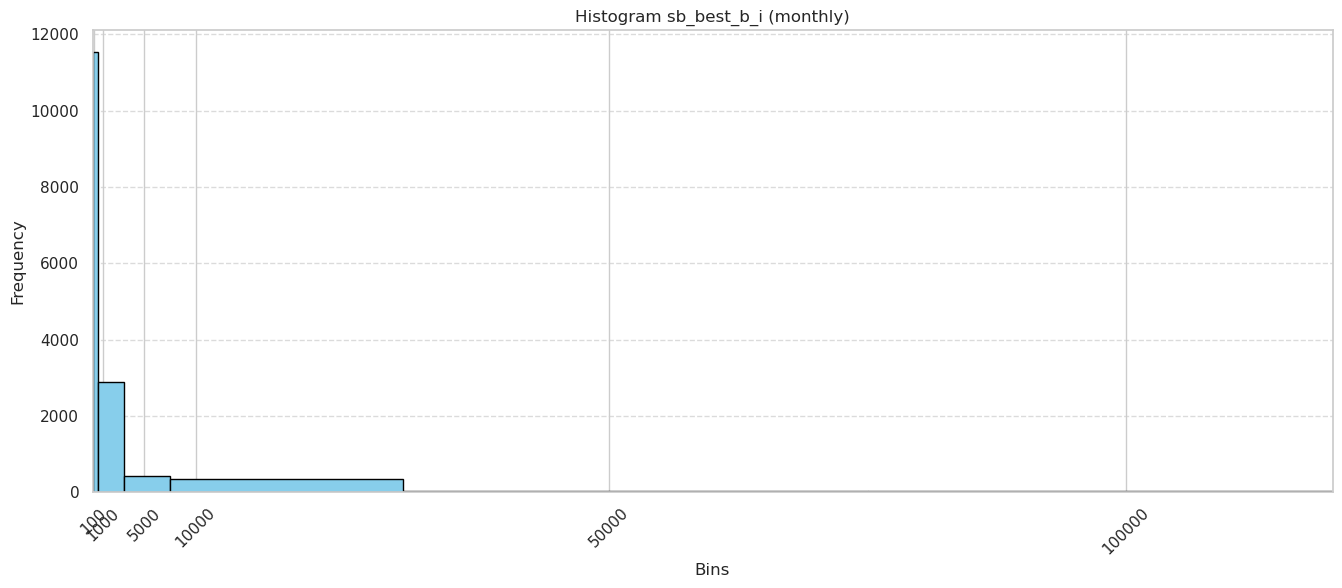

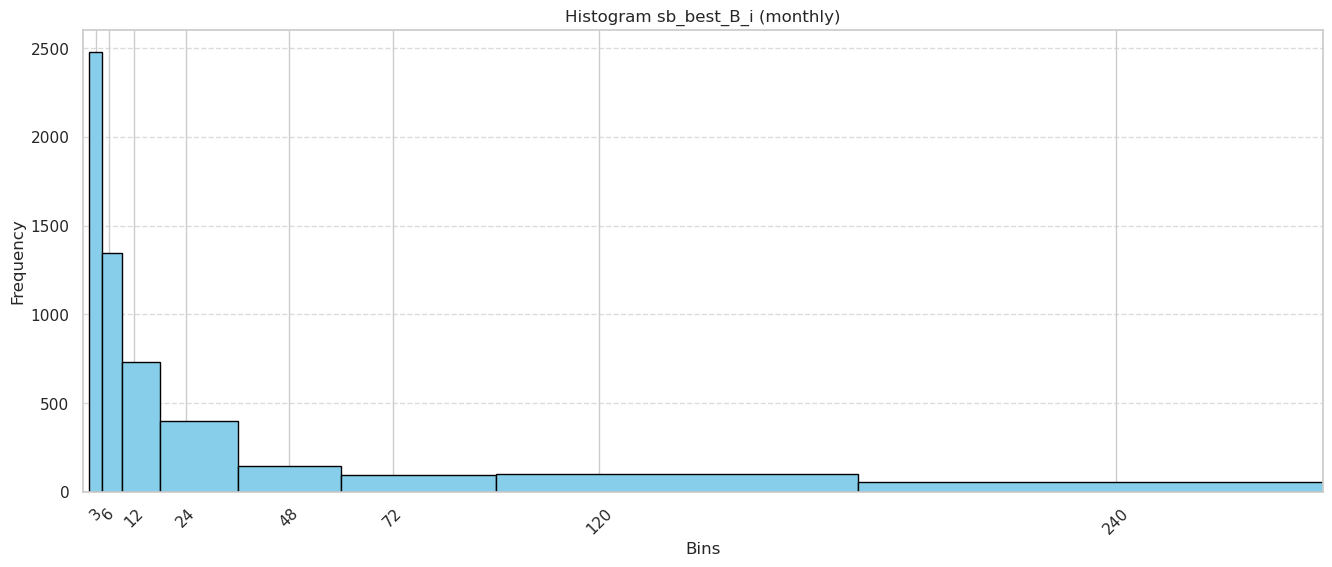

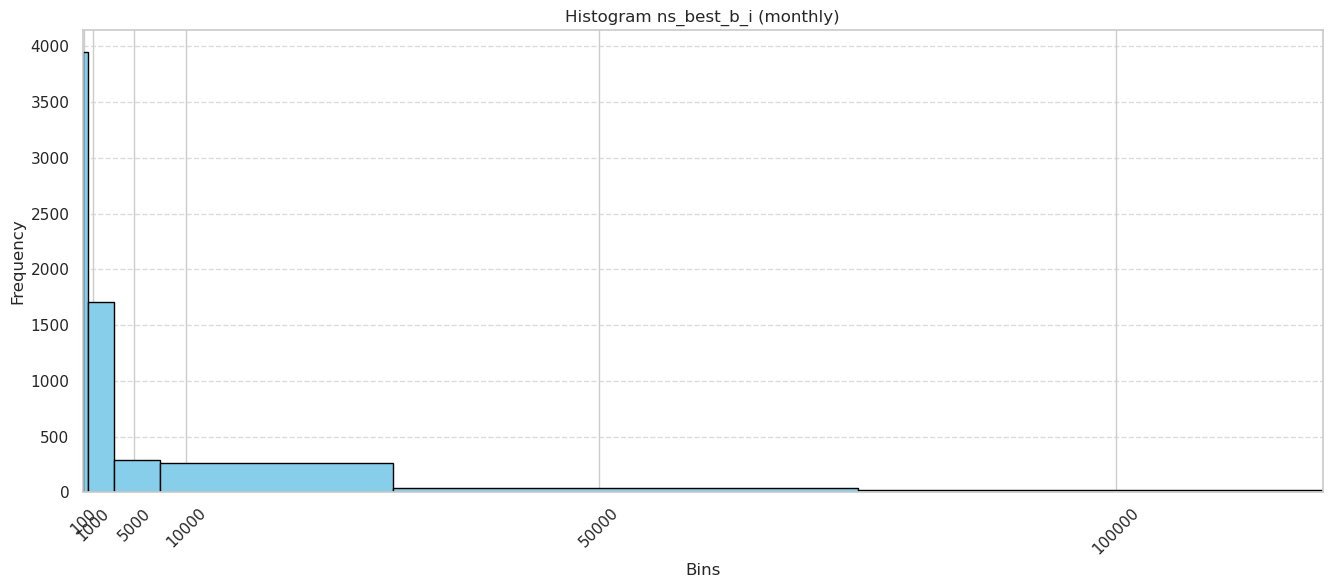

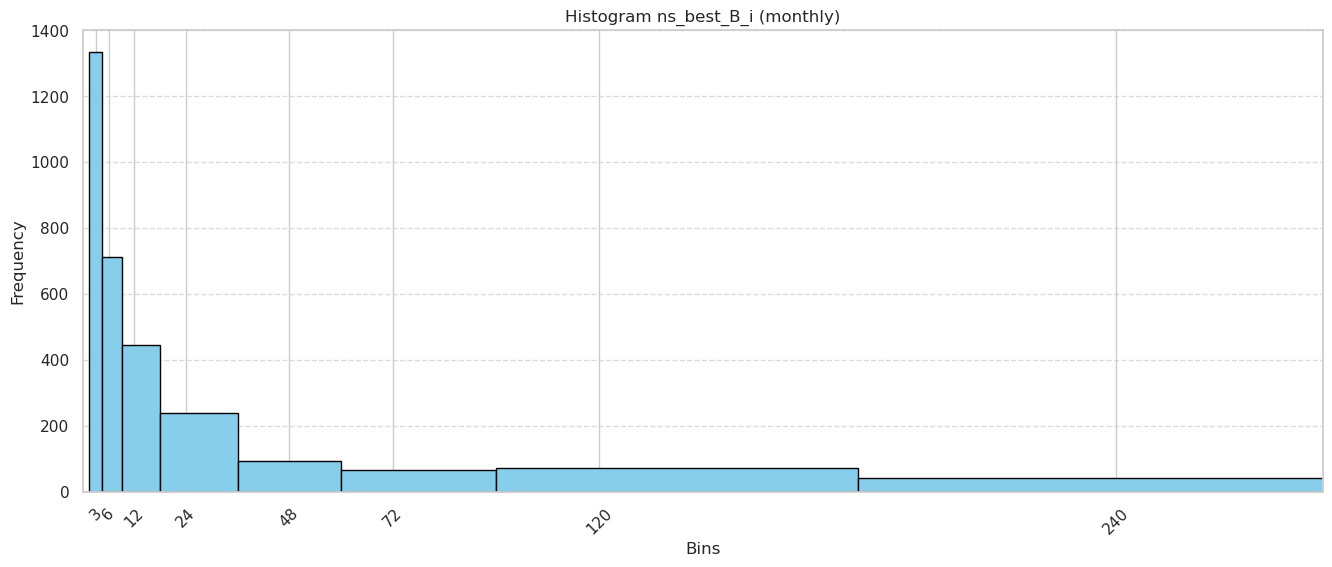

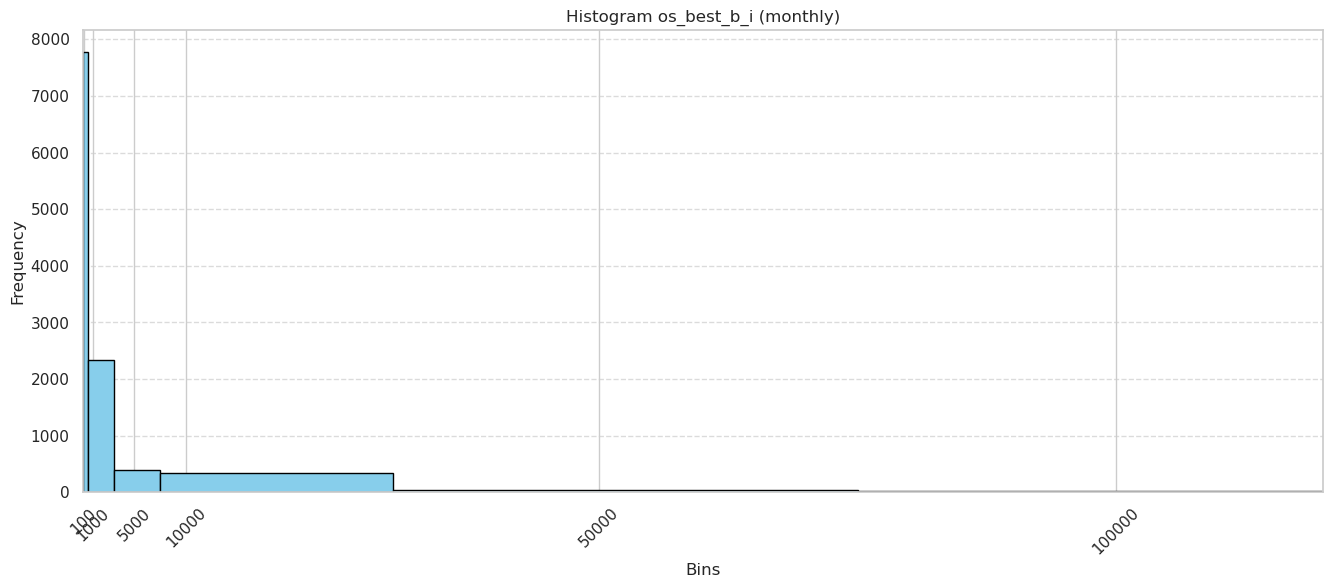

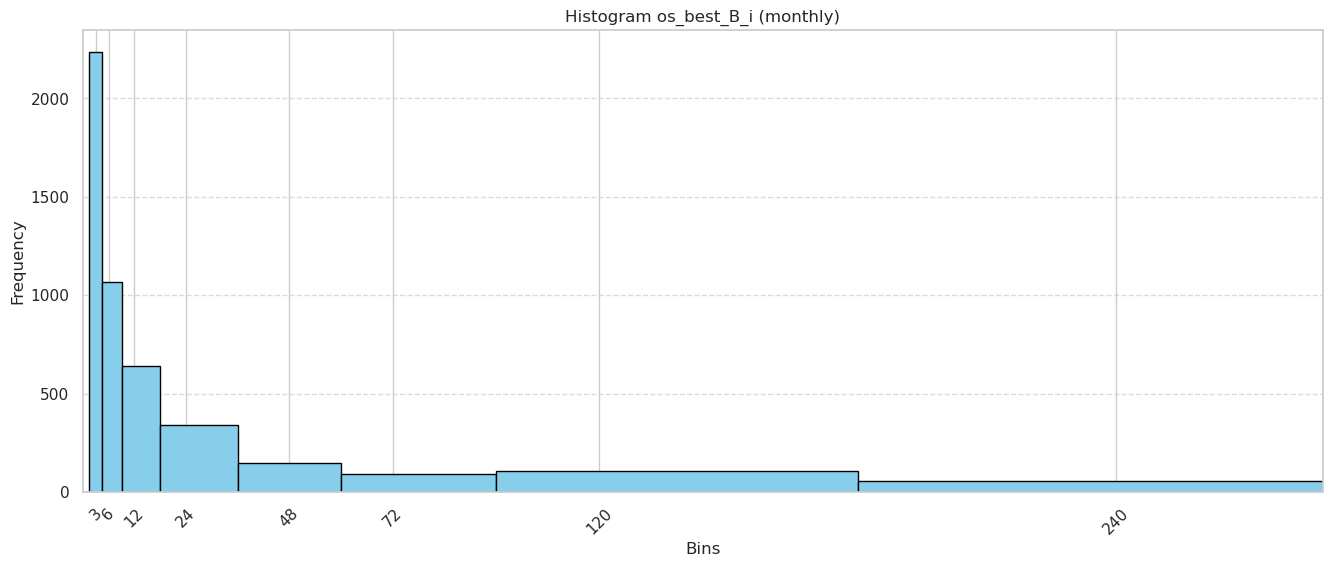

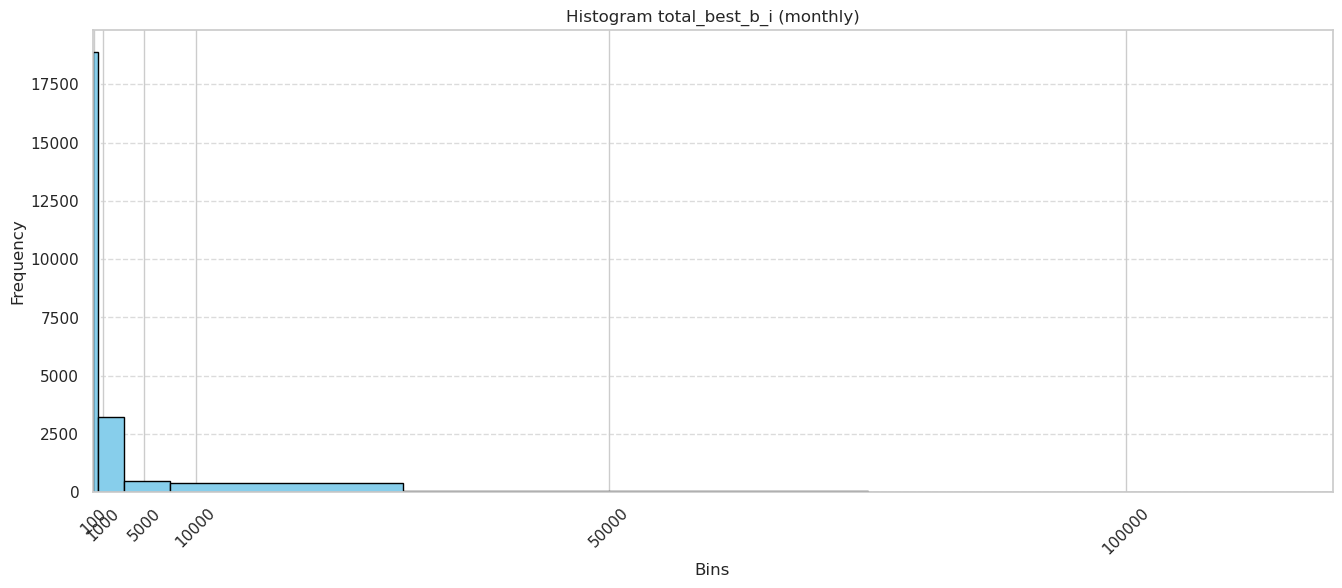

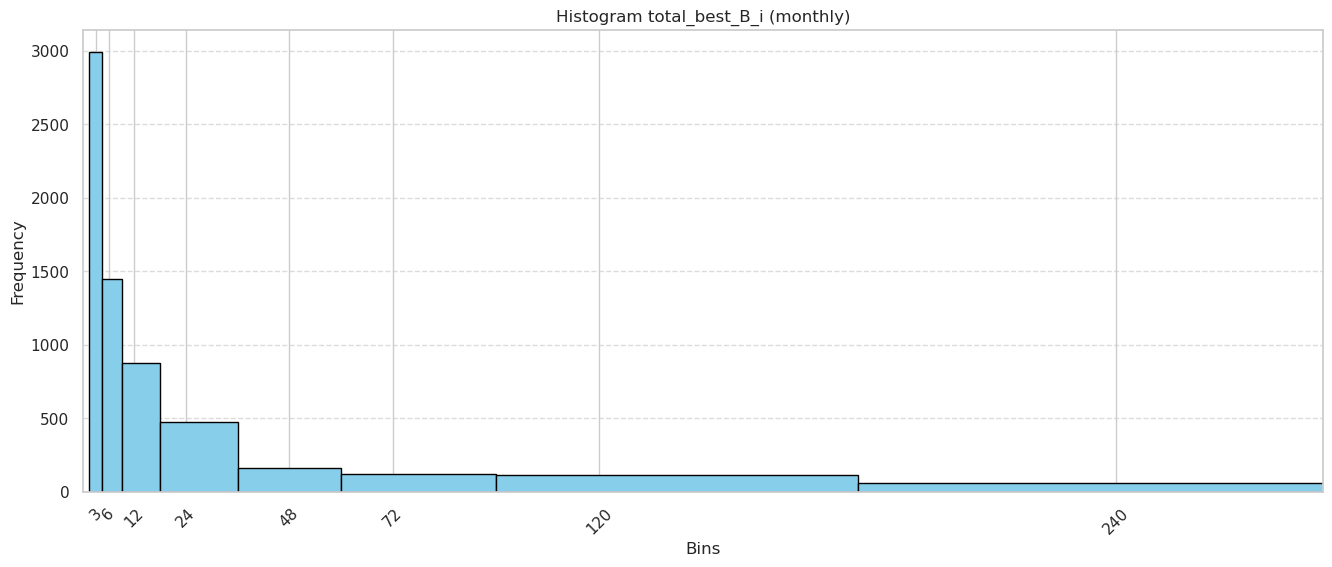

In [11]:
plot_binned_features(df_monthly, bin_list_monthly)

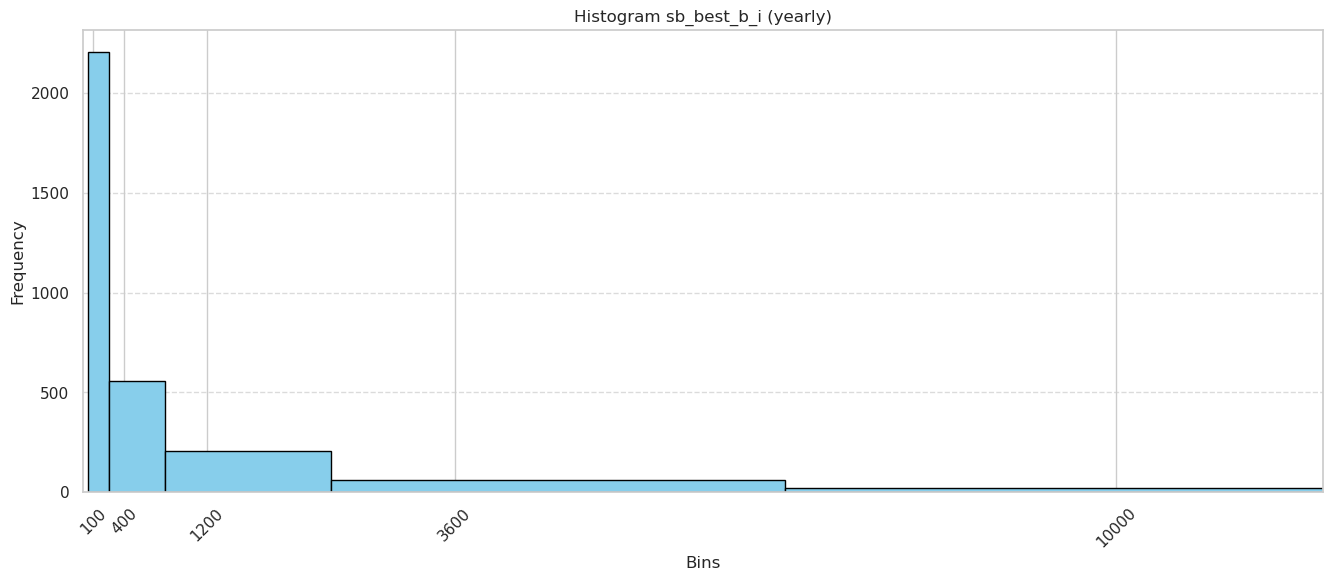

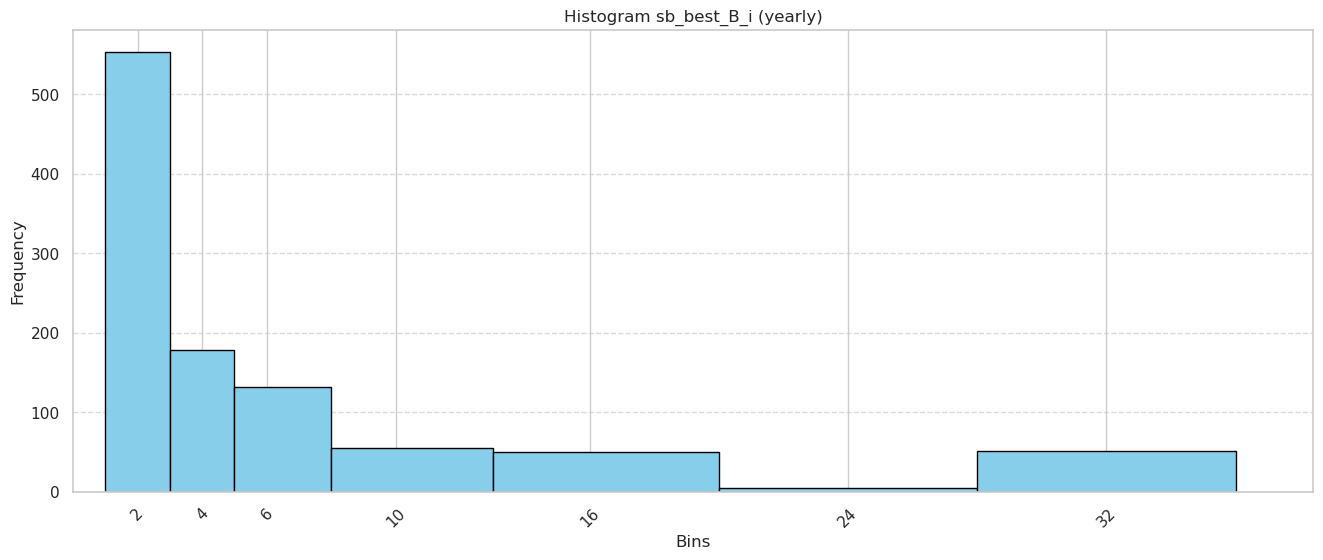

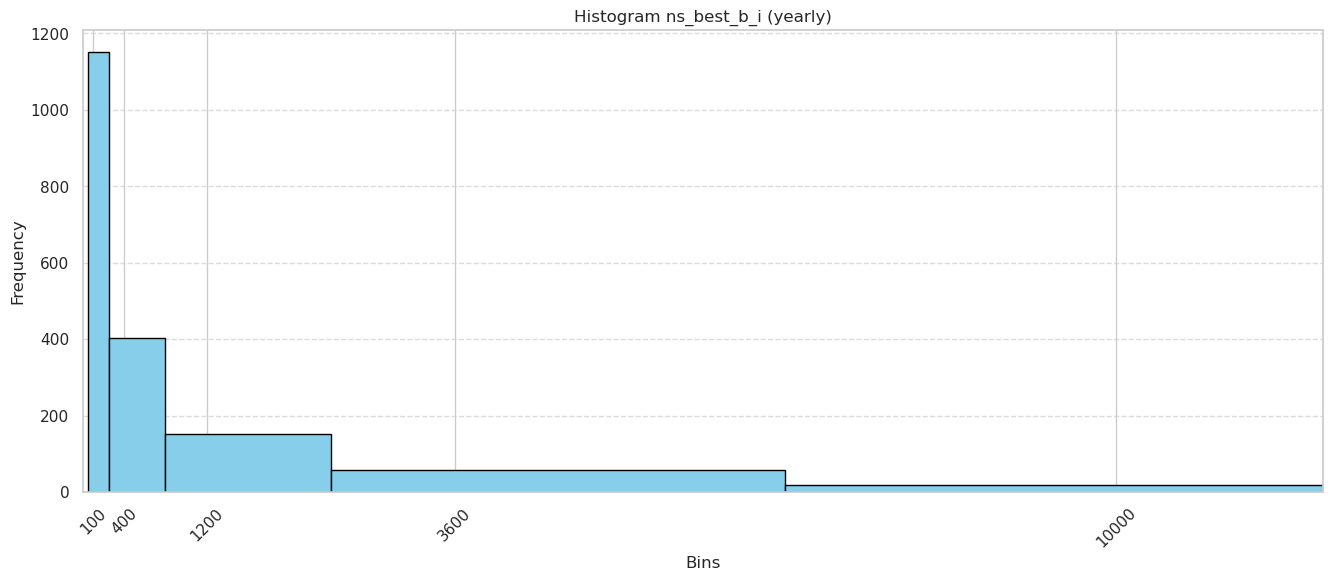

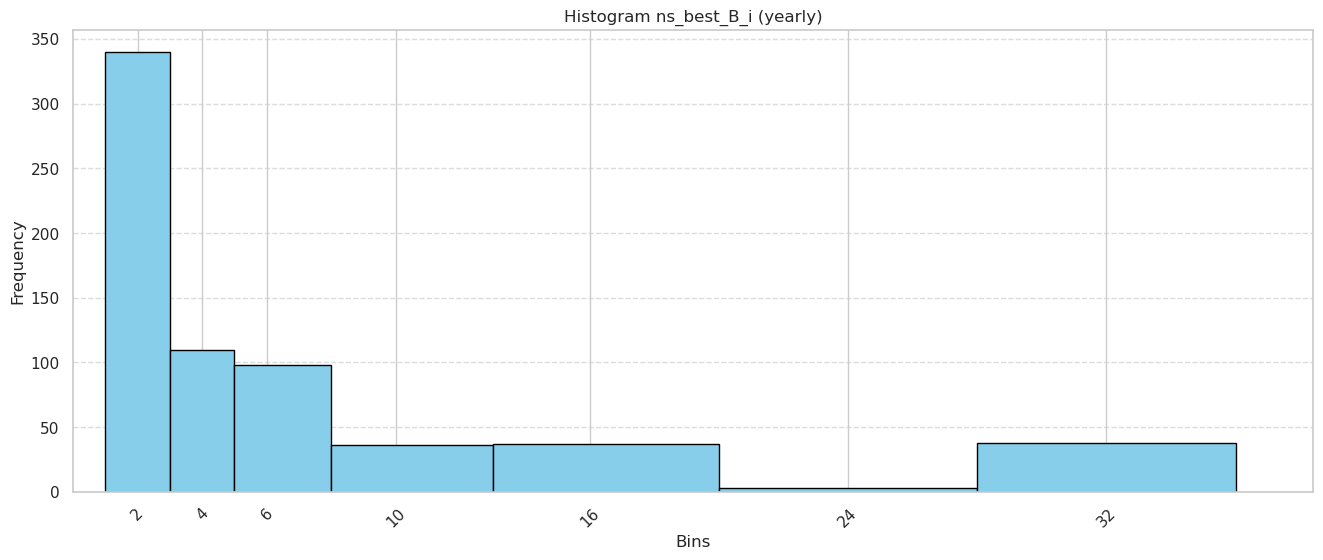

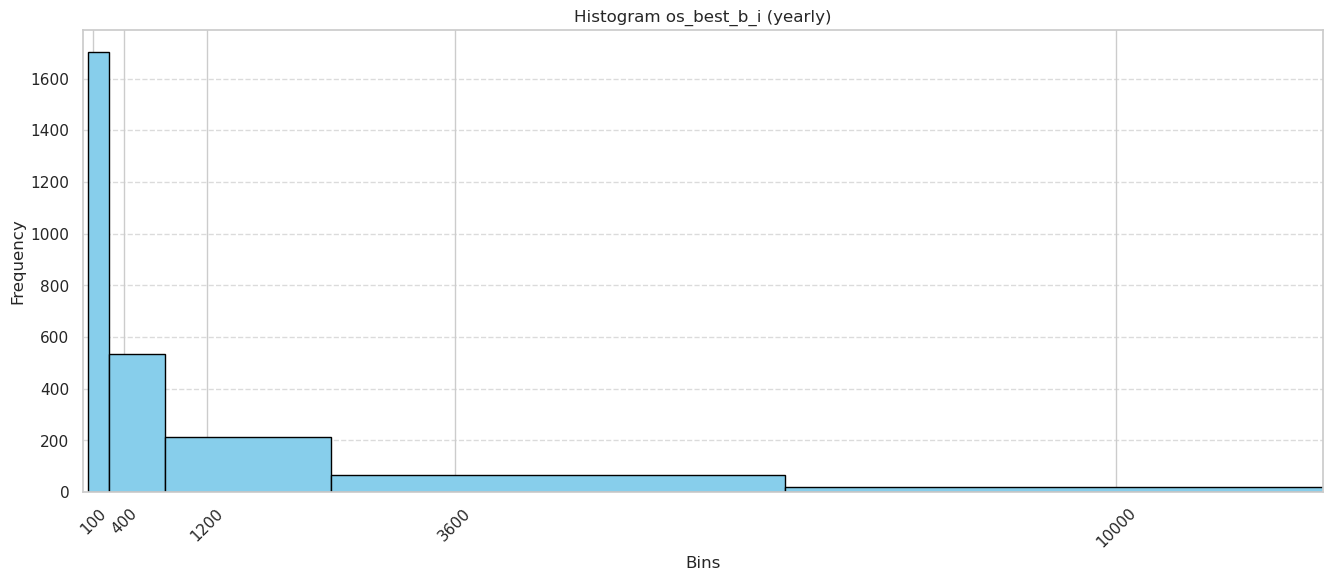

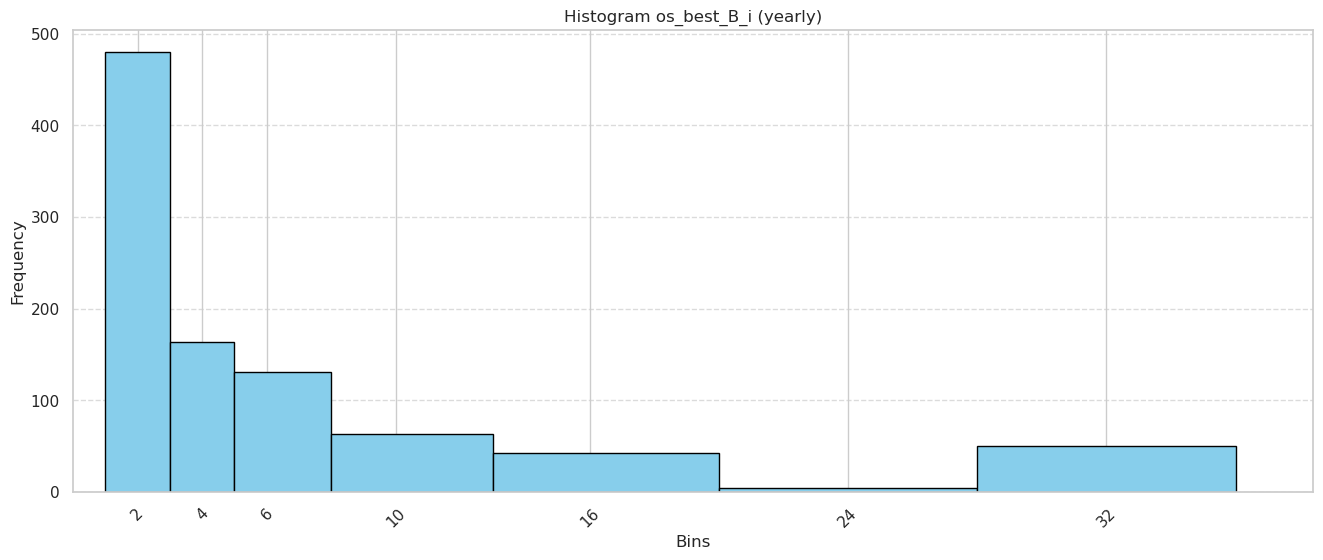

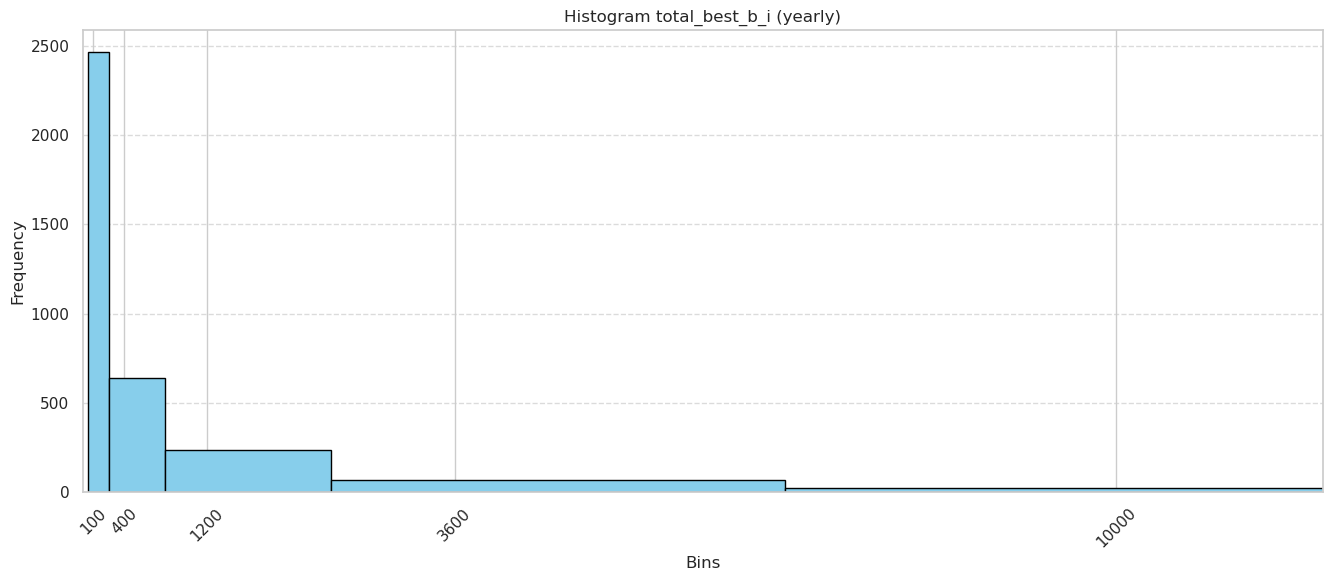

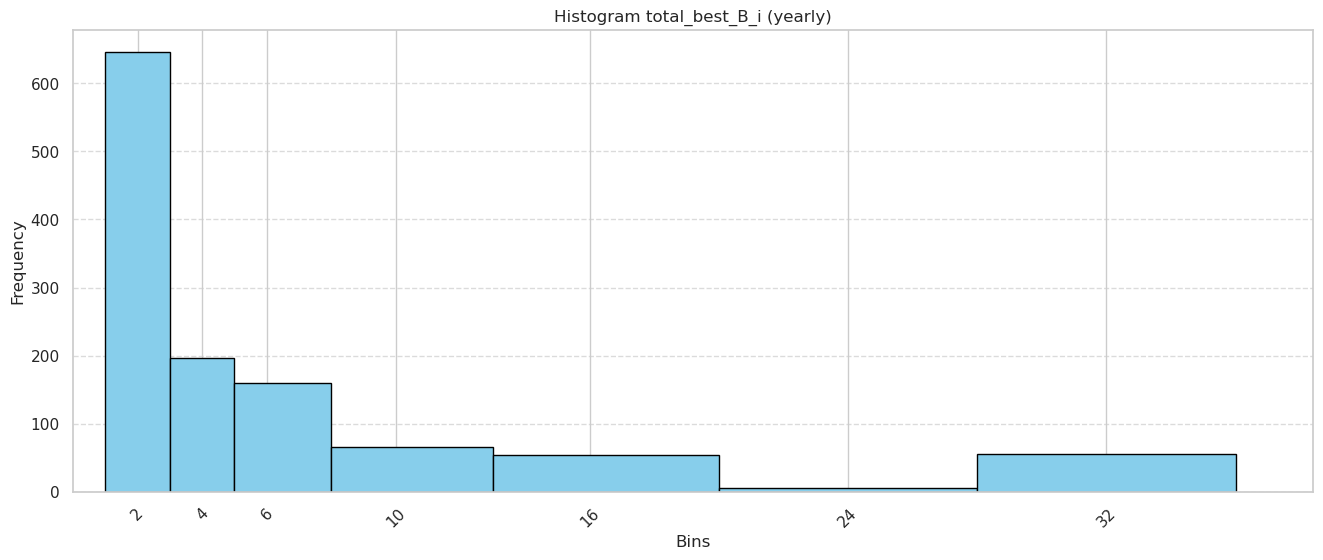

In [12]:
plot_binned_features(df_yearly, bin_list_yearly)